___

<a href='https://www.capitalbikeshare.com'> <img src='../img/CapitalBikeshare_Logo.jpg' /></a>

___

<h1 align="center"><a href='https://www.kaggle.com/c/bike-sharing-demand'>Kaggle Competition Project</a></h1> 
___

# 1. Goal


Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.


___

** Import Apache Spark 2.1libraries and setup environment variables. In case for cluster deployment you should probably remove this cell. **

In [402]:
import os
import sys
import time

# Change to path where apache spark 2.x is downloaded
SPARK_PATH = '/users/suchy/Documents/spark-2.1.0-bin-hadoop2.7'
os.environ['SPARK_HOME'] = SPARK_PATH

SPARK_HOME = os.environ['SPARK_HOME']

#Add the following paths to the system path.
sys.path.insert(0,os.path.join(SPARK_HOME,"python"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","pyspark.zip"))
sys.path.insert(0,os.path.join(SPARK_HOME,"python","lib","py4j-0.10.4-src.zip"))

** Initialize Spark Context for driver program **

In [403]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

conf = (SparkConf()
         .setAppName("Capital_Bike_weather_mining")
         .set("spark.executor.memory", "4g")
         .set("spark.driver.memory", "8g"))
        #.setMaster("yarn") - for cluster deployment
    
sc = SparkContext.getOrCreate(conf = conf)
sqlContext = SQLContext(sc)
sc = sc.setCheckpointDir("checkpoint")

** Import pandas, numpy, matplotlib,and seaborn. Then set %matplotlib inline **

In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
from sklearn import preprocessing
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.special import inv_boxcox
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

___
# 2. Get the Data
___

We are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. We must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data Fields:

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals
<img src='../img/bikes.png' /></a>

** Read in the Customers Bike Rental csv train and test files as a Pandas DataFrame.**

In [405]:
train_df = pd.read_csv("../data/train.csv")

In [406]:
test_df = pd.read_csv("../data/test.csv")

** There are 3 dependent variables: casual, registered and count (casual + registered) **. 

** We will try both methods: predict amount of casual and regitered rentals separately and predict sum of those (count) **

In [407]:
train_df.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [408]:
test_df.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2  2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3  2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4  2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

** Check out customers rental info() and describe() methods. Thera are total 10866 entries for traing data and 6493 entries for test data, none of the column has missing values**

In [409]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [410]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


In [411]:
continuous_var = ['temp', 'atemp', 'humidity', 'windspeed'] 

# exclude binary variables
categorical_var=['season','weather','year','month','hour','dayofweek','weekofyear','quarter','hour_cat', 'temp_cat']

dependent_variables = ['casual', 'registered', 'count']
dependent_variables_log = ['casual_log', 'registered_log', 'count_log']
dependent_variables_bc = ['casual_bc', 'registered_bc', 'count_bc']
# dependent_variables_cat used for ChiSqSelector, which works only for classified labels
dependent_variables_cat = ['casual_cat', 'registered_cat', 'count_cat']

added_cat_var = ['season_cat', 'month_cat', 'dayofweek_cat', 'weather_cat']


seasonDict = {1: "Winter", 2 : "Spring", 3 : "Summer", 4 :"Fall" }
monthDict = {1: "January", 2 : "February", 3 : "March", 4 :"April" ,\
             5 : "May", 6 : "June", 7 : "July", 8 :"August" ,\
             9: "September", 10 : "October", 11 : "November", 12 :"December"}
dayofweekDict = {0: "Monday", 1 : "Tuesday", 2 : "Wednesday", 3 :"Thursday" ,\
                 4 : "Friday", 5 : "Saturday", 6 : "Sunday"}
weatherDict = {1: "Clear", 2 : "Mist", 3 : "Light_Snow", 4 :"Heavy_Rain" }

** Data preparation part: parse data timestamp, add dummy and derivated variables. For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. So it's good idea to have categorical variables with similar level of unique values. ** 

**Lot's of data from the function below are taken in next section of Exploratory Data Analysis, like rental peak hours.**

In [412]:
def set_derivated_vars(dataset):   
    customers_rental = dataset.copy()
    
    # create derivate variable: day-to-day and hour change for continuous variables
    for var in continuous_var:   
        #customers_rental[var+'_prev_hour_change_pct'] = customers_rental[var].pct_change(periods=1) * 100
        # to make positive values means percentage increase of variable in next hour
        customers_rental[var+'_next_hour_change_pct'] = customers_rental[var].pct_change(periods=-1)*(-1) * 100
        #customers_rental[var+'_prev_day_change_pct'] = customers_rental[var].pct_change(periods=24) * 100
        customers_rental[var+'_next_day_change_pct'] = customers_rental[var].pct_change(periods=-24) *(-1) * 100
    
    customers_rental['atemp_temp_diff'] = customers_rental['atemp'] - customers_rental['temp']

    # first day don't have pct_change, as well as there are some divide by zero operation (inf)
    customers_rental = customers_rental.replace([np.inf, -np.inf], np.nan)
    
    # Replace nan by interpolating, first argument can't be NaN for interpolation to works,
    # In Pandas interpolate implementation NaN variable above the range 
    # will we interpolated as well (like extrapolation)
    customers_rental.iloc[0] = customers_rental.iloc[0].fillna(customers_rental.mean())
    customers_rental = customers_rental.interpolate(method='time')
    customers_rental = set_temp_cat(customers_rental)
    
    return customers_rental

In [413]:
def set_temp_cat(dataset):
    customers_rental = dataset.copy()
    
    # create additional variable about rental traffic by temp, 
    # specific hours are taken from Exploratoty Data Analysis from clustermap by the end of next section
    customers_rental['temp_cat'] = 0
    customers_rental.loc[(customers_rental['temp'].round() <= 12), 'temp_cat'] = 1
    customers_rental.loc[(customers_rental['temp'].round() >= 13) & (customers_rental['temp'].round() <= 30) & \
                         (customers_rental['workingday'] == 0), 'temp_cat'] = 2
    customers_rental.loc[(customers_rental['temp'].round() >= 13) & (customers_rental['temp'].round() <= 30) & \
                         (customers_rental['workingday'] == 1),'temp_cat'] = 3
    customers_rental.loc[(customers_rental['temp'].round() >= 31), 'temp_cat'] = 4     
    
    return customers_rental

In [414]:
def set_hour_cat(dataset):
    customers_rental = dataset.copy()
    
    # create additional variable about rental traffic by hour, 
    # specific hours are taken from Exploratoty Data Analysis from clustermap by the end of next section
    customers_rental['hour_cat'] = 1
    customers_rental.loc[(customers_rental['hour'] <= 6) | (customers_rental['hour'] == 23), 'hour_cat'] = 2
    customers_rental.loc[(customers_rental['hour'] >= 7) & (customers_rental['hour'] <= 8) & \
                         (customers_rental['workingday'] == 1), 'hour_cat'] = 3
    customers_rental.loc[(customers_rental['hour'] >= 10) & (customers_rental['hour'] <= 16) & \
                         (customers_rental['workingday'] == 0), 'hour_cat'] = 3
    customers_rental.loc[(customers_rental['hour'] >= 17) & (customers_rental['hour'] <= 18) & \
                         (customers_rental['workingday'] == 1), 'hour_cat'] = 3   
    customers_rental.loc[((customers_rental['hour'] >= 20) & (customers_rental['hour'] <= 22)) | \
                         (customers_rental['hour'] == 9), 'hour_cat'] = 4
    
    return customers_rental

In [415]:
def set_independent_weather(dataset):
    customers_rental = dataset.copy()
    
    #############################################
    # data taken from independent source weather
    # https://www.washingtonpost.com/blogs/capital-weather-gang/post/2011-in-washington-dc-warm-with-extreme-weather-aplenty/2011/12/27/gIQAnNXSMP_blog.html?utm_term=.7a2584169af6
    # https://www.washingtonpost.com/blogs/capital-weather-gang/post/top-5-dc-weather-events-of-2012/2012/12/28/d384311c-4f0e-11e2-950a-7863a013264b_blog.html?utm_term=.1a10a3265c33
    #############################################
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 15), "workingday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 16), "workingday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 15), "holiday"] = 0
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 4) \
                         & (customers_rental['day'] == 16), "holiday"] = 0

    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 25), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 23), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 25), "workingday"] = 0
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 11) \
                     & (customers_rental['day'] == 23), "workingday"] = 0
    
    customers_rental.loc[(customers_rental['month'] == 12) \
                     & ((customers_rental['day'] == 24) | \
                        (customers_rental['day'] == 26)), "workingday"] = 0
    customers_rental.loc[(customers_rental['month'] == 12) \
                     & ((customers_rental['day'] == 24) | \
                        (customers_rental['day'] == 25) | \
                       (customers_rental['day'] == 26)), "holiday"] = 1
    
    # 2011
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 1) \
                     & (customers_rental['day'] == 26), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 9) \
                     & (customers_rental['day'] >= 4) & (customers_rental['day'] <= 8), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 8) \
                     & (customers_rental['day'] == 28), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] == 4) \
                     & (customers_rental['day'] >= 27) & (customers_rental['day'] <= 28), "holiday"] = 1
    # 2012
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 10) \
                     & (customers_rental['day'] == 30), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 3) \
                     & (customers_rental['day'] == 2), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 6) \
                     & (customers_rental['day'] == 1), "holiday"] = 1
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 6) \
                     & (customers_rental['day'] == 29), "holiday"] = 1    
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] == 5) \
                     & (customers_rental['day'] == 21), "holiday"] = 1  
    
    return customers_rental

In [416]:
def prepare_data(dataset):
    customers_rental = dataset.copy()
    
    # next_hour_weather is category for next hour weather 
    next_hour_weather = customers_rental['weather'].copy()
    next_hour_weather[:len(next_hour_weather)-1] = next_hour_weather[1:len(next_hour_weather)]
    customers_rental['next_hour_weather'] = next_hour_weather.reset_index()['weather']
    
    dt = pd.DatetimeIndex(customers_rental['datetime'])
    customers_rental.set_index(dt, inplace=True)
    
    customers_rental['date'] = pd.to_datetime(customers_rental['datetime'])
    customers_rental["year"] = customers_rental["date"].dt.year
    customers_rental["month"] = customers_rental["date"].dt.month
    customers_rental["day"] = customers_rental["date"].dt.day
    customers_rental["hour"] = customers_rental["date"].dt.hour
    customers_rental["dayofweek"] = customers_rental["date"].dt.dayofweek
    customers_rental["weekofyear"] = customers_rental["date"].dt.weekofyear
    
    customers_rental["season_cat"] = customers_rental["season"].map(seasonDict)
    customers_rental["month_cat"] = customers_rental["month"].map(monthDict)    
    customers_rental["dayofweek_cat"] = customers_rental["dayofweek"].map(dayofweekDict)
    customers_rental["weather_cat"] = customers_rental["weather"].map(weatherDict)
    

    customers_rental['quarter'] = 0
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 0), 'quarter'] = 1
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 3), 'quarter'] = 2
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 6), 'quarter'] = 3
    customers_rental.loc[(customers_rental['year'] == 2011) & (customers_rental['month'] > 9), 'quarter'] = 4
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 0), 'quarter'] = 5
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 3), 'quarter'] = 6
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 6), 'quarter'] = 7
    customers_rental.loc[(customers_rental['year'] == 2012) & (customers_rental['month'] > 9), 'quarter'] = 8
    
    
    # from EDA 
    customers_rental['bike_season'] = 0
    customers_rental.loc[(customers_rental['month'] >= 4) & (customers_rental['month'] <= 11), 'bike_season'] = 1
    

    # create derivated variables, used among others in outliers detecion
    customers_rental = set_derivated_vars(customers_rental)
    customers_rental = set_hour_cat(customers_rental)
    customers_rental = set_independent_weather(customers_rental)
    
    
    # train data has days 1-19 of each month, test data > 20
    customers_rental['train'] = 0
    customers_rental.loc[(customers_rental['day'] < 20), 'train'] = 1
    
    
    # Apache Spark solver uses square loss function for minimalization. 
    # Our evalutation metric will be RMSLE so it's good idea to use logarithmic transformation 
    # of dependent cols (adding 1 first so that 0 values don't become -inf)
    #
    # Dependent_variables_cat used for ChiSqSelector, which works only for classified labels
    
    # lambda dictionary necessery for inverted boxcox transformation
    bc_lambda_dict = {}
    
    for col in dependent_variables:
        customers_rental.loc[(customers_rental['day'] >= 20), col] = 0
        customers_rental['%s_log' % col] = np.log(customers_rental[col] + 1)
        
        # boxcox transformation for 4 subsets in order to get better normal-like data distribution in each subset
        # subsets are splitted by similarity on hour's impact on bike's rental
        bc1 = boxcox(customers_rental[(customers_rental['hour_cat'] == 1) & (all_no_dummy['train'] == 1)][col] +1)
        bc2 = boxcox(customers_rental[(customers_rental['hour_cat'] == 2) & (all_no_dummy['train'] == 1)][col] +1)
        bc3 = boxcox(customers_rental[(customers_rental['hour_cat'] == 3) & (all_no_dummy['train'] == 1)][col] +1)
        bc4 = boxcox(customers_rental[(customers_rental['hour_cat'] == 4) & (all_no_dummy['train'] == 1)][col] +1)
        
        customers_rental['%s_bc' % col] = 0
        customers_rental.loc[(customers_rental['hour_cat'] == 1) & (all_no_dummy['train'] == 1), \
                             '%s_bc' % col] = bc1[0]
        customers_rental.loc[(customers_rental['hour_cat'] == 2) & (all_no_dummy['train'] == 1), \
                             '%s_bc' % col] = bc2[0]
        customers_rental.loc[(customers_rental['hour_cat'] == 3) & (all_no_dummy['train'] == 1), \
                             '%s_bc' % col] = bc3[0]
        customers_rental.loc[(customers_rental['hour_cat'] == 4) & (all_no_dummy['train'] == 1), \
                             '%s_bc' % col] = bc4[0]
                    
        customers_rental['%s_cat' % col] = 0
        customers_rental.loc[(customers_rental['day'] < 20), '%s_cat' % col] = \
            pd.cut(customers_rental.loc[(customers_rental['day'] < 20), '%s_bc' % col],\
                   bins=96, labels=range(0,96), include_lowest=True)
        
        bc_lambda_dict[col] = [bc1[1], bc2[1], bc3[1], bc4[1]]
        
    # drop unnecessary variables
    customers_rental.drop(['datetime','date'], axis=1, inplace=True)
   
    return customers_rental, bc_lambda_dict

** We will use dataset with dummy variables for linear regression ** **We will use dataset without dummy varaibles for random forest regression and gradient boosted regression. bc_lambda_dict is dictionary for lambdas used in BoxCox transformation, and used for inverted BoxCox transformation.**

In [417]:
all_no_dummy, bc_lambda_dict = prepare_data(train_df.append(test_df))

** Columns structure (without dummies) after data preparation part. Later we will explore which set of those columns use for machine learning models. **

In [418]:
all_no_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 45 columns):
atemp                             17379 non-null float64
casual                            17379 non-null float64
count                             17379 non-null float64
holiday                           17379 non-null int64
humidity                          17379 non-null int64
registered                        17379 non-null float64
season                            17379 non-null int64
temp                              17379 non-null float64
weather                           17379 non-null int64
windspeed                         17379 non-null float64
workingday                        17379 non-null int64
next_hour_weather                 17379 non-null int64
year                              17379 non-null int64
month                             17379 non-null int64
day                               17379 non-null int64
hour               

# 3. Exploratory Data Analysis
** Let's explore the data! **

In [419]:
sns.set_palette("coolwarm")
sns.set_style('whitegrid')

** Median of continuous variables looks reasonably. There are many outliers in windspeed variable and some outliers for zero humidity. **

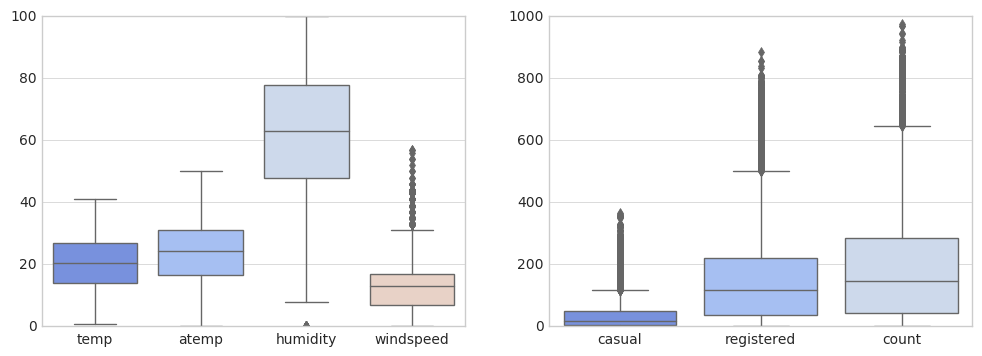

In [420]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(12,4))
sns.boxplot(data=all_no_dummy[continuous_var], ax=ax1)
sns.boxplot(data=all_no_dummy[all_no_dummy['train'] == 1][dependent_variables], ax=ax2)

** Let's find out what is distribution curves for dependent variables. Most of the current machine learning algorithmics performs best on normally distributed data. Pure distribution of depednent variables look more to be Poisson than Gaussian. Log transformation can helps a lot in converting data to normal-like distribution but BoxCox method do the best job by automatically detect proportion (lambda) of log and sqrt transformation. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


<function matplotlib.pyplot.tight_layout>

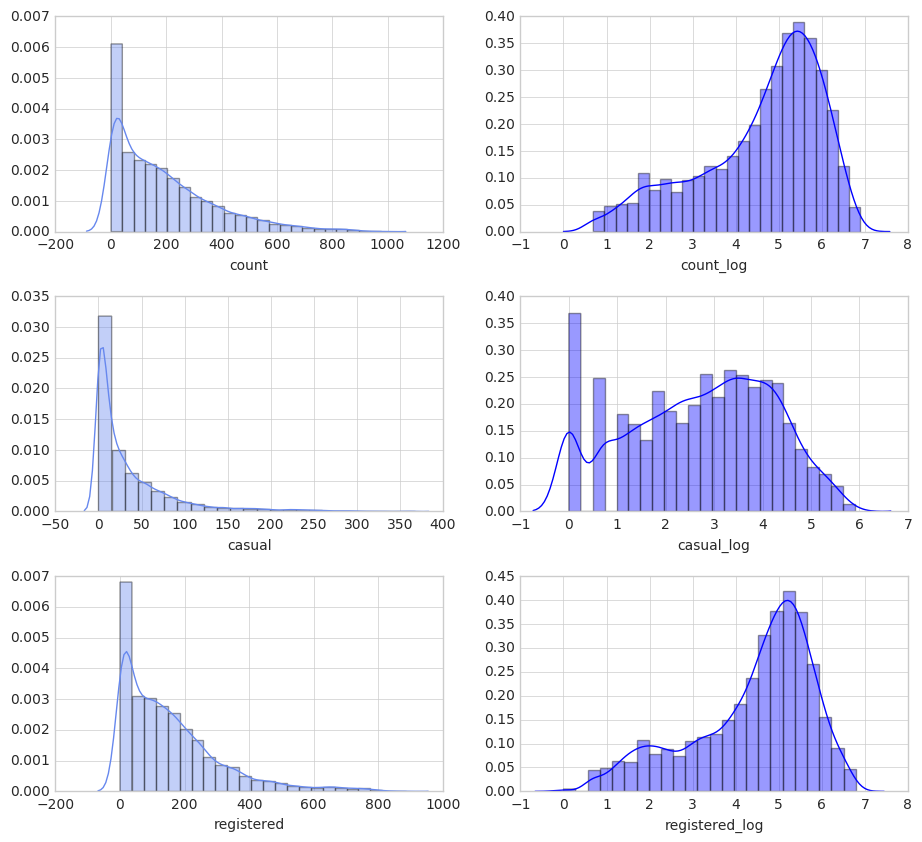

In [421]:
fig,axes= plt.subplots(nrows=3, ncols=2, figsize=(11,10))

sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['count'], bins = 24, ax=axes[0][0])
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['count_log'], bins = 24, ax=axes[0][1], color='blue')
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['casual'], bins = 24, ax=axes[1][0])
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['casual_log'], bins = 24, ax=axes[1][1], color='blue')
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['registered'], bins = 24, ax=axes[2][0])
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['registered_log'], bins = 24, ax=axes[2][1], color='blue')
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** We can see that LOG distribution looks more normal-like but it's clearly skewed. BoxCox helps us deal with it. But first let's examine raw data divided into 4 hour categories. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


<function matplotlib.pyplot.tight_layout>

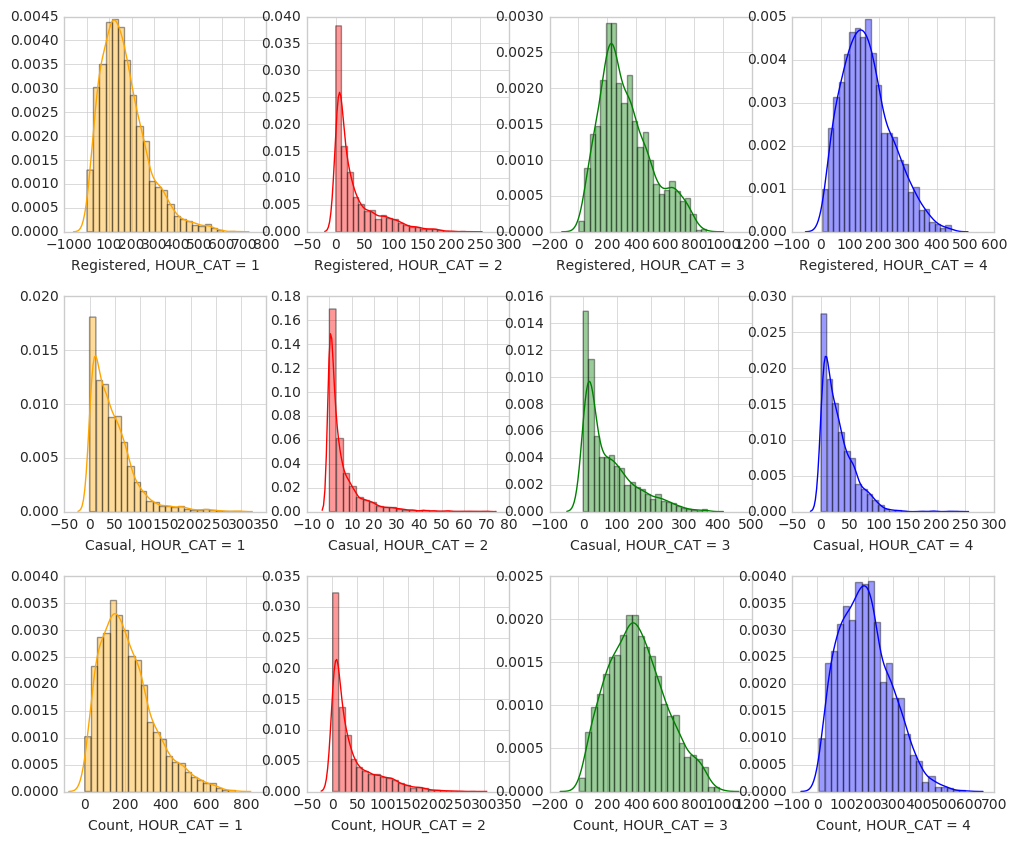

In [422]:
fig,axes= plt.subplots(nrows=3, ncols=4, figsize=(12,10))

sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 1) & (all_no_dummy['train'] == 1)]['registered'], bins = 24, ax=axes[0][0], axlabel='Registered, HOUR_CAT = 1', color='orange')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 2) & (all_no_dummy['train'] == 1)]['registered'], bins = 24, ax=axes[0][1], axlabel='Registered, HOUR_CAT = 2', color='red')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 3) & (all_no_dummy['train'] == 1)]['registered'], bins = 24, ax=axes[0][2], axlabel='Registered, HOUR_CAT = 3', color='green')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 4) & (all_no_dummy['train'] == 1)]['registered'], bins = 24, ax=axes[0][3], axlabel='Registered, HOUR_CAT = 4', color='blue')

sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 1) & (all_no_dummy['train'] == 1)]['casual'], bins = 24, ax=axes[1][0], axlabel='Casual, HOUR_CAT = 1', color='orange')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 2) & (all_no_dummy['train'] == 1)]['casual'], bins = 24, ax=axes[1][1], axlabel='Casual, HOUR_CAT = 2', color='red')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 3) & (all_no_dummy['train'] == 1)]['casual'], bins = 24, ax=axes[1][2], axlabel='Casual, HOUR_CAT = 3', color='green')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 4) & (all_no_dummy['train'] == 1)]['casual'], bins = 24, ax=axes[1][3], axlabel='Casual, HOUR_CAT = 4', color='blue')

sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 1) & (all_no_dummy['train'] == 1)]['count'], bins = 24, ax=axes[2][0], axlabel='Count, HOUR_CAT = 1', color='orange')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 2) & (all_no_dummy['train'] == 1)]['count'], bins = 24, ax=axes[2][1], axlabel='Count, HOUR_CAT = 2', color='red')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 3) & (all_no_dummy['train'] == 1)]['count'], bins = 24, ax=axes[2][2], axlabel='Count, HOUR_CAT = 3', color='green')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 4) & (all_no_dummy['train'] == 1)]['count'], bins = 24, ax=axes[2][3], axlabel='Count, HOUR_CAT = 4', color='blue')


plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** Data are highly skewed. It's time to use BoxCox transformation. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


<function matplotlib.pyplot.tight_layout>

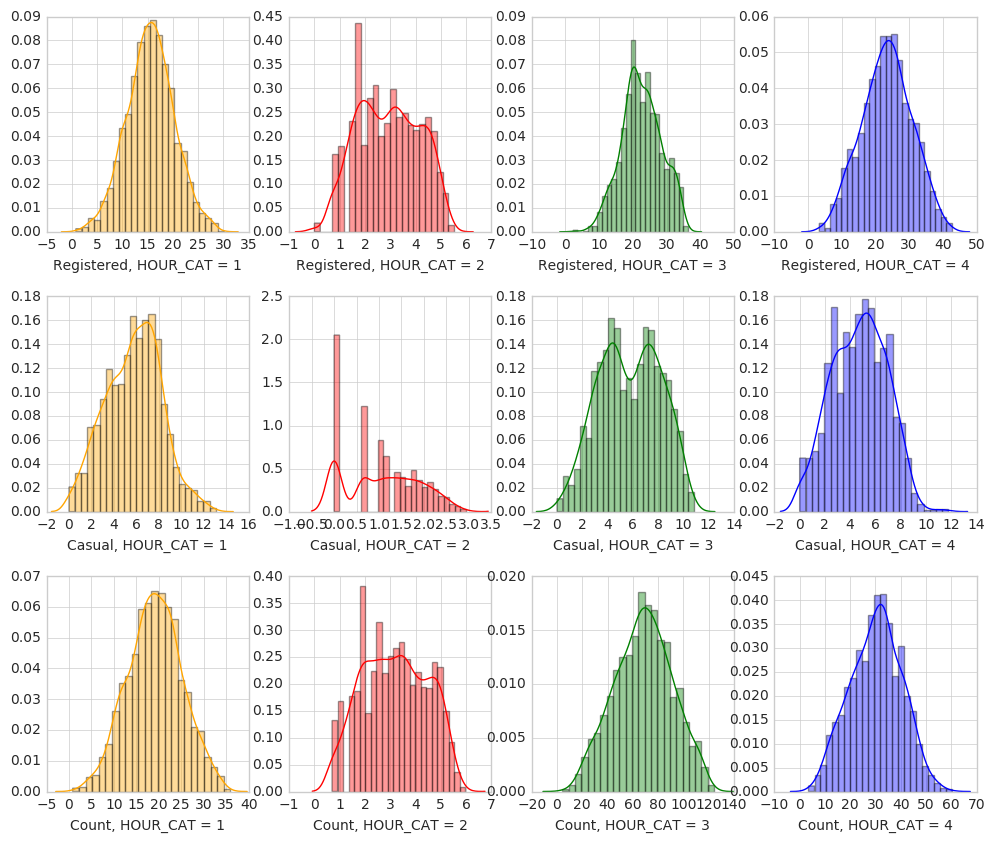

In [423]:
fig,axes= plt.subplots(nrows=3, ncols=4, figsize=(12,10))

sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 1) & (all_no_dummy['train'] == 1)]['registered_bc'], bins = 24, ax=axes[0][0], axlabel='Registered, HOUR_CAT = 1', color='orange')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 2) & (all_no_dummy['train'] == 1)]['registered_bc'], bins = 24, ax=axes[0][1], axlabel='Registered, HOUR_CAT = 2', color='red')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 3) & (all_no_dummy['train'] == 1)]['registered_bc'], bins = 24, ax=axes[0][2], axlabel='Registered, HOUR_CAT = 3', color='green')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 4) & (all_no_dummy['train'] == 1)]['registered_bc'], bins = 24, ax=axes[0][3], axlabel='Registered, HOUR_CAT = 4', color='blue')

sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 1) & (all_no_dummy['train'] == 1)]['casual_bc'], bins = 24, ax=axes[1][0], axlabel='Casual, HOUR_CAT = 1', color='orange')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 2) & (all_no_dummy['train'] == 1)]['casual_bc'], bins = 24, ax=axes[1][1], axlabel='Casual, HOUR_CAT = 2', color='red')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 3) & (all_no_dummy['train'] == 1)]['casual_bc'], bins = 24, ax=axes[1][2], axlabel='Casual, HOUR_CAT = 3', color='green')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 4) & (all_no_dummy['train'] == 1)]['casual_bc'], bins = 24, ax=axes[1][3], axlabel='Casual, HOUR_CAT = 4', color='blue')

sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 1) & (all_no_dummy['train'] == 1)]['count_bc'], bins = 24, ax=axes[2][0], axlabel='Count, HOUR_CAT = 1', color='orange')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 2) & (all_no_dummy['train'] == 1)]['count_bc'], bins = 24, ax=axes[2][1], axlabel='Count, HOUR_CAT = 2', color='red')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 3) & (all_no_dummy['train'] == 1)]['count_bc'], bins = 24, ax=axes[2][2], axlabel='Count, HOUR_CAT = 3', color='green')
sns.distplot(all_no_dummy[(all_no_dummy['hour_cat'] == 4) & (all_no_dummy['train'] == 1)]['count_bc'], bins = 24, ax=axes[2][3], axlabel='Count, HOUR_CAT = 4', color='blue')


plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** Right now only casual rental in hour_cat = 2 (from 23 p.m till 6 a.m) are skewed toward zero. Rest of the distributions look good. Let's test those distribution with Kolmogorov-Smirnov Test. P-Value above 0.05 will reject distribution as to be Gaussian one. **

In [424]:
for col in dependent_variables:
    print("Kolmogorov-Smirnov Test for " + col)
    for hour_cat in range(1,5):
        print("Hour_cat " + str(hour_cat) + ": " + str(kstest(all_no_dummy[(all_no_dummy['hour_cat'] == hour_cat) & (all_no_dummy['train'] == 1)]['%s_bc' % col], 'norm')))
    print()

Kolmogorov-Smirnov Test for casual
Hour_cat 1: KstestResult(statistic=0.91168126337657251, pvalue=0.0)
Hour_cat 2: KstestResult(statistic=0.5, pvalue=0.0)
Hour_cat 3: KstestResult(statistic=0.92566429720227272, pvalue=0.0)
Hour_cat 4: KstestResult(statistic=0.88281995210734343, pvalue=0.0)

Kolmogorov-Smirnov Test for registered
Hour_cat 1: KstestResult(statistic=0.99623129414256539, pvalue=0.0)
Hour_cat 2: KstestResult(statistic=0.83495240909494395, pvalue=0.0)
Hour_cat 3: KstestResult(statistic=0.99936444716526129, pvalue=0.0)
Hour_cat 4: KstestResult(statistic=0.99957832183090556, pvalue=0.0)

Kolmogorov-Smirnov Test for count
Hour_cat 1: KstestResult(statistic=0.99706056423598699, pvalue=0.0)
Hour_cat 2: KstestResult(statistic=0.85430970482173085, pvalue=0.0)
Hour_cat 3: KstestResult(statistic=0.99999261302830289, pvalue=0.0)
Hour_cat 4: KstestResult(statistic=0.99977408350679475, pvalue=0.0)



** All distribution passed test, let's find out what is skew for those distributions. The closer to zero the better. **

In [425]:
for col in dependent_variables:
    print("Distribution skew for " + col)
    for hour_cat in range(1,5):
        print("Hour_cat " + str(hour_cat) + ": " + str(skew(all_no_dummy[(all_no_dummy['hour_cat'] == hour_cat) & (all_no_dummy['train'] == 1)]['%s_bc' % col])))
    print()

Distribution skew for casual
Hour_cat 1: -0.04180344829109071
Hour_cat 2: 0.0752360392791642
Hour_cat 3: -0.0685101933851219
Hour_cat 4: -0.05705643615167112

Distribution skew for registered
Hour_cat 1: -0.005263477715926078
Hour_cat 2: -0.0017961706908505312
Hour_cat 3: -0.027042077415409642
Hour_cat 4: -0.048950344253321135

Distribution skew for count
Hour_cat 1: -0.030367799538066356
Hour_cat 2: -0.007436688820979168
Hour_cat 3: -0.071742645336669
Hour_cat 4: -0.06738229925462827



** Let's compare those results skews with raw data. **

In [426]:
for col in dependent_variables:
    print("Distribution skew for " + col)
    for hour_cat in range(1,5):
        print("Hour_cat " + str(hour_cat) + ": " + str(skew(all_no_dummy[(all_no_dummy['hour_cat'] == hour_cat) & (all_no_dummy['train'] == 1)][col])))
    print()

Distribution skew for casual
Hour_cat 1: 1.915373561806957
Hour_cat 2: 2.8784190358835127
Hour_cat 3: 1.2607866725835637
Hour_cat 4: 1.7067208789734591

Distribution skew for registered
Hour_cat 1: 1.1036516780051626
Hour_cat 2: 1.670210056178679
Hour_cat 3: 0.7123795941553138
Hour_cat 4: 0.6014442083269638

Distribution skew for count
Hour_cat 1: 0.9196037086035667
Hour_cat 2: 1.6380820687868343
Hour_cat 3: 0.3577288591403938
Hour_cat 4: 0.5215310146527776



** Looks like we did big improvement. Good work. **

### Let's dive deeper into each continuous variable
** Explore data of daily average of one hour bike rentals across all years 2011 and 2012. Sliding windows is of interval 7 days for dependent variables and 3 days for continuous independent variables. Default are set to 75 percentage change computed as (a-b)/b. ** 

In [427]:
outliers = {}

def plot_with_window(column, dataset=all_no_dummy,  all=True, threshold=75):   
    if (all):
        day_avg = 3
        data = dataset
        data_window_mean = data.rolling(window=day_avg * 24).mean()
        data_window_std = data.rolling(window=day_avg * 24).std()
        title = column + ' over time'
        
    else:
        day_avg = 7
        data = dataset[all_no_dummy['train'] == 1].groupby(['year','month','day']).mean()
        data_window_mean = data.rolling(window=day_avg).mean()
        data_window_std = data.rolling(window=day_avg).std()
        title = 'Daily mean of ' + column + ' over time'
    
    diff = np.abs(data[column] - data_window_mean[column])
    # diff for outliers candidates has to be at least above threshold % to avoid false outliers
    outliers = diff[(diff > 3 * data_window_std[column]) & (diff > threshold)]

    plt.figure(figsize=(9,4))
    data[column].plot()
    data_window_mean[column].plot(label=str(day_avg) + ' Day Avg', lw=1, ls='--', c='red')
    
    plt.legend(loc='best')
    plt.title(title)
    plt.tight_layout()
    
    
    return outliers

In [428]:
def unique_outliers(col_list):
    outliers_list = []
    for col in col_list:
        for timestamp in outliers[col].index:
            outliers_list.append(timestamp)
    return sorted(list(set(outliers_list)))

** Characterics of casual renting is very changeable with many positive peaks. **

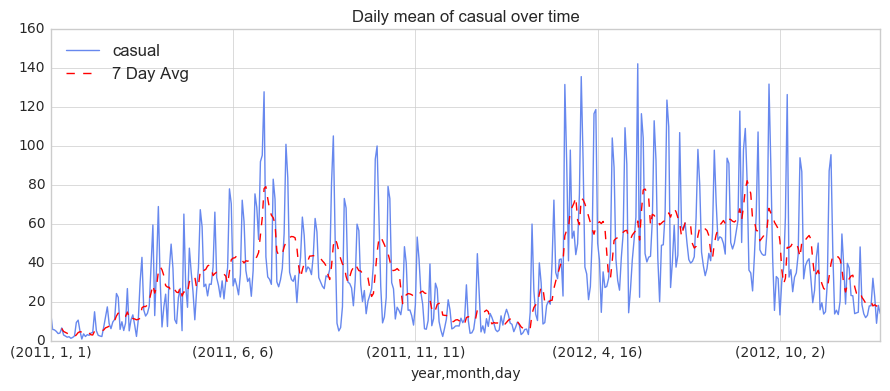

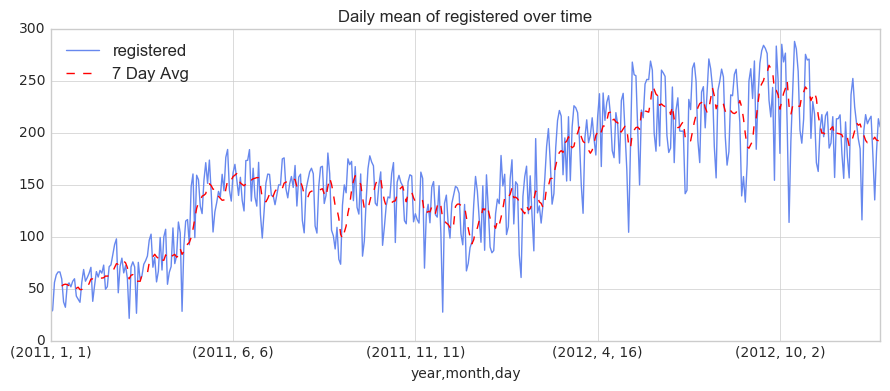

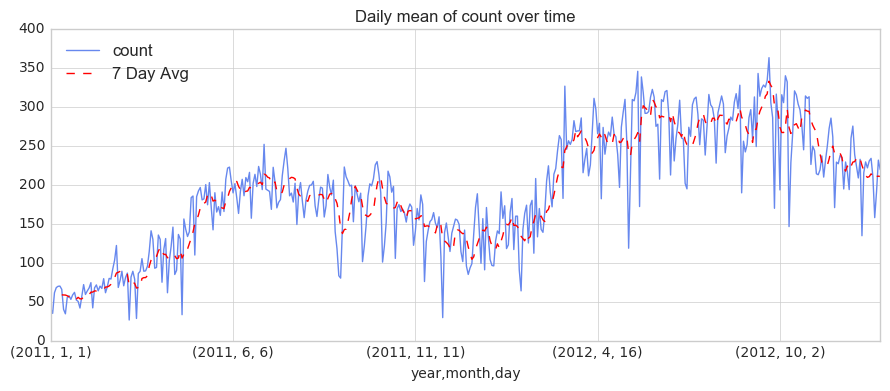

In [429]:
for col in dependent_variables: 
    outliers[col] = plot_with_window(col, all=False, threshold=10)

** Plot for registred users looks almost the same becouse on average about 80% of total rentals are made be registered users. **

In [430]:
all_no_dummy[all_no_dummy['train'] == 1][['casual', 'registered', 'count']].describe().ix['mean']

casual         36.021955
registered    155.552177
count         191.574132
Name: mean, dtype: float64

** Thera are no outliers for dependent variables (by our criteria). **

In [431]:
all_no_dummy.ix[unique_outliers(dependent_variables)]

Empty DataFrame
Columns: [atemp, casual, count, holiday, humidity, registered, season, temp, weather, windspeed, workingday, next_hour_weather, year, month, day, hour, dayofweek, weekofyear, season_cat, month_cat, dayofweek_cat, weather_cat, quarter, bike_season, temp_next_hour_change_pct, temp_next_day_change_pct, atemp_next_hour_change_pct, atemp_next_day_change_pct, humidity_next_hour_change_pct, humidity_next_day_change_pct, windspeed_next_hour_change_pct, windspeed_next_day_change_pct, atemp_temp_diff, temp_cat, hour_cat, train, casual_log, casual_bc, casual_cat, registered_log, registered_bc, registered_cat, count_log, count_bc, count_cat]
Index: []

** Let's find out whether there are some weather data outliers. **

In [432]:
temp_var_list = ['temp',
            #'temp_prev_hour_change_pct',
            'temp_next_hour_change_pct',
            #'temp_prev_day_change_pct',             
            'temp_next_day_change_pct']

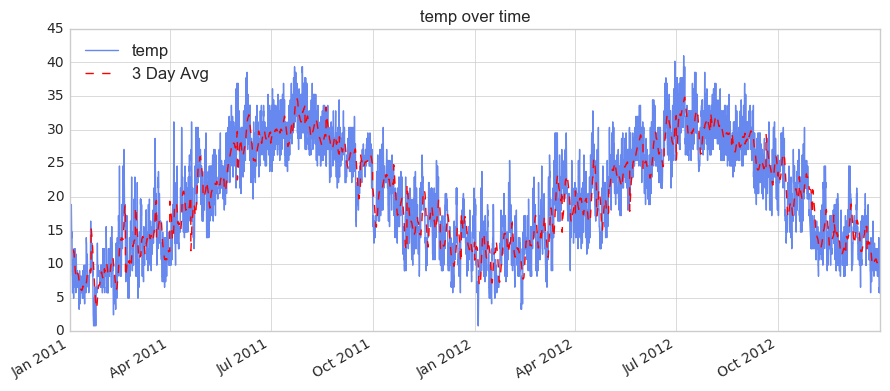

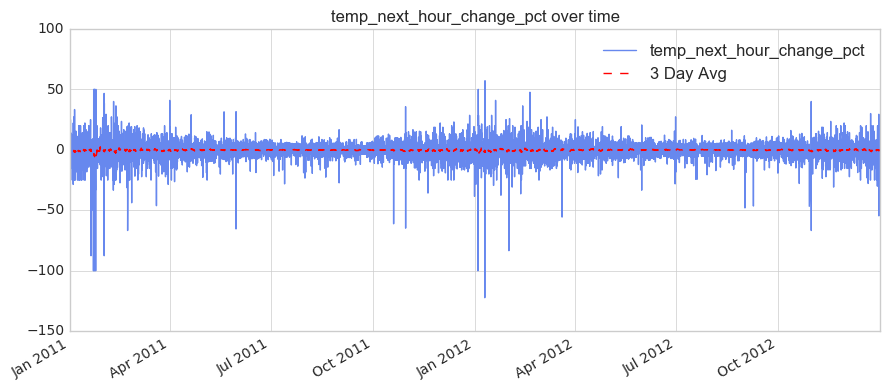

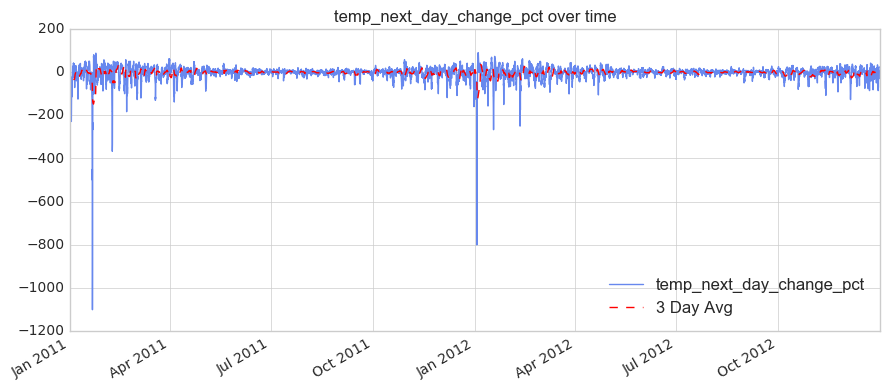

In [433]:
for col in temp_var_list: 
    outliers[col] = plot_with_window(col)

** Some of the outliers below. **

In [434]:
all_no_dummy.ix[unique_outliers(temp_var_list), temp_var_list].head()

temp  temp_next_hour_change_pct  \
2011-01-08 04:00:00   7.38                 -12.500000   
2011-01-19 23:00:00  12.30                 -87.500000   
2011-01-20 15:00:00  13.12                  -6.666667   
2011-01-20 17:00:00  12.30                 -15.384615   
2011-01-20 18:00:00  10.66                  -0.000000   

                     temp_next_day_change_pct  
2011-01-08 04:00:00               -125.000000  
2011-01-19 23:00:00                -36.363636  
2011-01-20 15:00:00               -100.000000  
2011-01-20 17:00:00               -114.285714  
2011-01-20 18:00:00               -116.666667

In [435]:
atemp_var_list = ['atemp',
            #'atemp_prev_hour_change_pct',
            'atemp_next_hour_change_pct',
            #'atemp_prev_day_change_pct',             
            'atemp_next_day_change_pct']

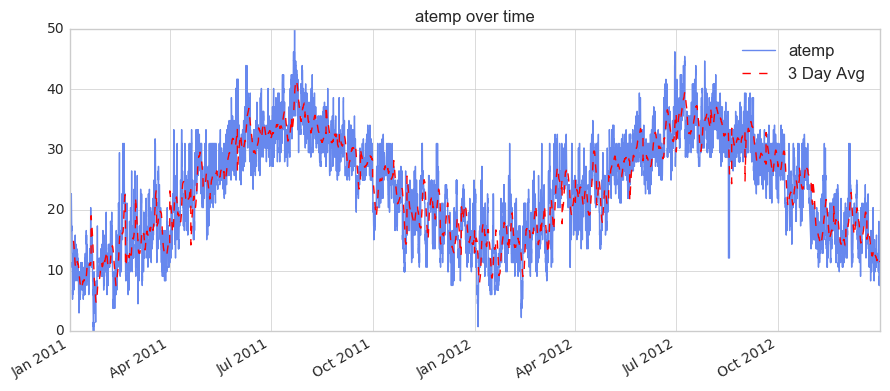

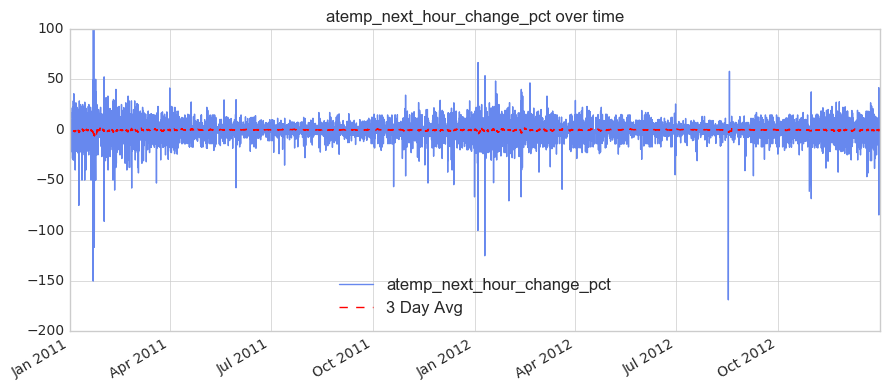

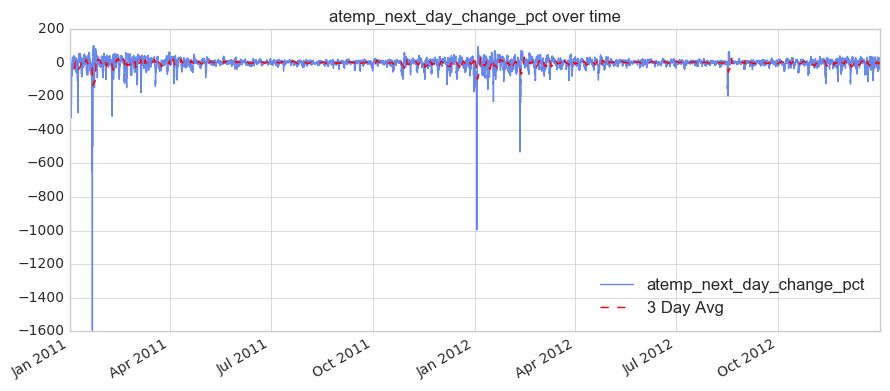

In [436]:
for col in atemp_var_list: 
    outliers[col] = plot_with_window(col)

In [437]:
all_no_dummy.ix[unique_outliers(atemp_var_list)][atemp_var_list].head()

atemp  atemp_next_hour_change_pct  \
2011-01-07 17:00:00  12.880                  -13.330400   
2011-01-07 23:00:00   9.850                   -0.000000   
2011-01-08 00:00:00   9.850                    7.119283   
2011-01-08 01:00:00  10.605                   12.500000   
2011-01-08 02:00:00  12.120                  -23.045685   

                     atemp_next_day_change_pct  
2011-01-07 17:00:00                -112.541254  
2011-01-07 23:00:00                -225.082508  
2011-01-08 00:00:00                -159.894459  
2011-01-08 01:00:00                -250.000000  
2011-01-08 02:00:00                -300.000000

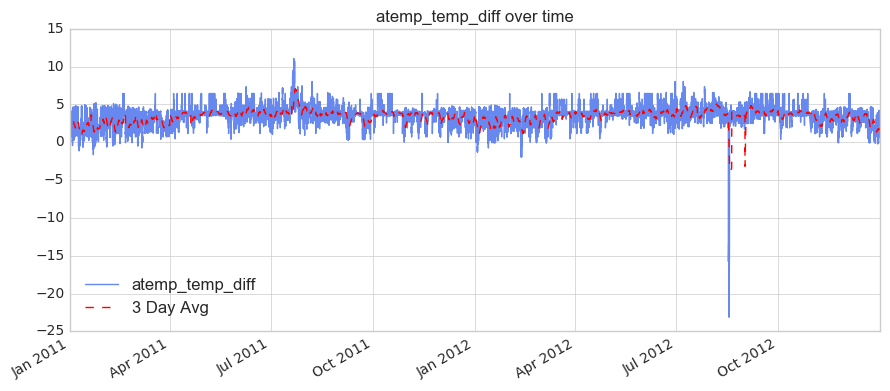

In [438]:
outliers['atemp_temp_diff'] = plot_with_window('atemp_temp_diff', threshold=10)

In [439]:
all_no_dummy.ix[unique_outliers(['atemp_temp_diff'])]['atemp_temp_diff'].head(400)

2012-08-17 00:00:00   -15.76
2012-08-17 01:00:00   -14.94
2012-08-17 02:00:00   -14.94
2012-08-17 03:00:00   -14.12
2012-08-17 04:00:00   -14.12
2012-08-17 05:00:00   -14.12
Name: atemp_temp_diff, dtype: float64

** We can see one clear outlier in humidity. During minium day for count variable (2011, 3, 6), humidity had one of its highest value. It matches our understanding - there are fewer bike rentals during rain. On (2011, 3, 10) humidity has zero daily mean value although in adjacent days there was high value for humidity. It looks like some missing values. **

In [440]:
all_no_dummy.groupby(['year','month','day']).mean().idxmin()

atemp                              (2011, 1, 22)
casual                             (2011, 1, 20)
count                              (2011, 1, 20)
holiday                             (2011, 1, 1)
humidity                           (2011, 3, 10)
registered                         (2011, 1, 20)
season                              (2011, 1, 1)
temp                               (2011, 1, 22)
weather                             (2011, 1, 3)
windspeed                          (2011, 10, 7)
workingday                          (2011, 1, 1)
next_hour_weather                   (2011, 1, 3)
hour                              (2012, 10, 29)
dayofweek                           (2011, 1, 3)
weekofyear                          (2011, 1, 3)
quarter                             (2011, 1, 1)
bike_season                         (2011, 1, 1)
temp_next_hour_change_pct         (2012, 10, 29)
temp_next_day_change_pct           (2011, 1, 21)
atemp_next_hour_change_pct        (2012, 10, 29)
atemp_next_day_chang

In [441]:
humidity_var_list = ['humidity',
            #'humidity_prev_hour_change_pct',
            'humidity_next_hour_change_pct',
            #'humidity_prev_day_change_pct',             
            'humidity_next_day_change_pct']

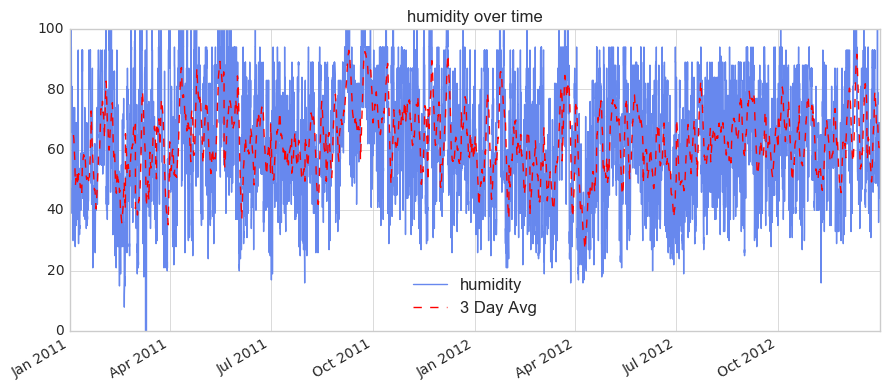

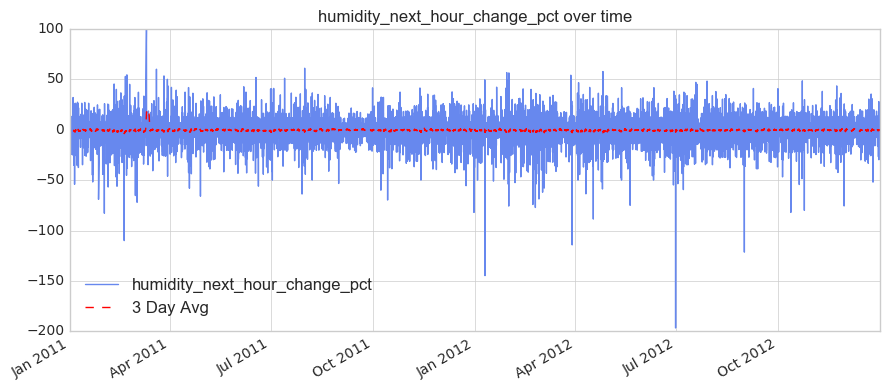

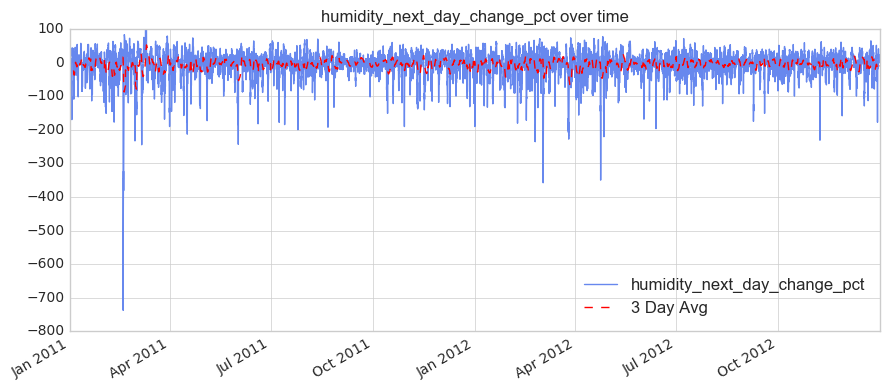

In [442]:
for col in humidity_var_list: 
    outliers[col] = plot_with_window(col)

In [443]:
all_no_dummy.ix[unique_outliers(humidity_var_list)][humidity_var_list].head()

humidity  humidity_next_hour_change_pct  \
2011-01-08 08:00:00        93                      -0.000000   
2011-01-08 09:00:00        93                     -16.250000   
2011-01-11 15:00:00        80                       6.976744   
2011-01-11 16:00:00        86                      -0.000000   
2011-01-11 17:00:00        86                       7.526882   

                     humidity_next_day_change_pct  
2011-01-08 08:00:00                    -89.795918  
2011-01-08 09:00:00                   -102.173913  
2011-01-11 15:00:00                    -70.212766  
2011-01-11 16:00:00                    -82.978723  
2011-01-11 17:00:00                    -82.978723

** Windspeed becouse of its nature has very inregular characteriscs but in a way it has some stable mean level. Looks like this variable doesn't add value for our predictive models. **

In [444]:
windspeed_var_list = ['windspeed',
            #'windspeed_prev_hour_change_pct',
            'windspeed_next_hour_change_pct',
            #'windspeed_prev_day_change_pct',             
            'windspeed_next_day_change_pct']

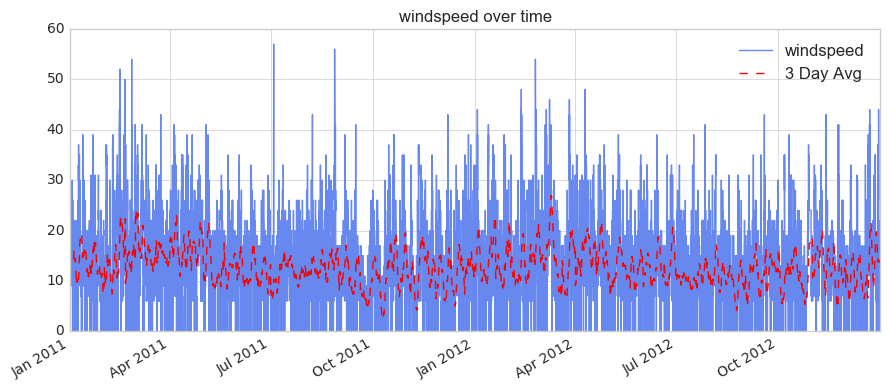

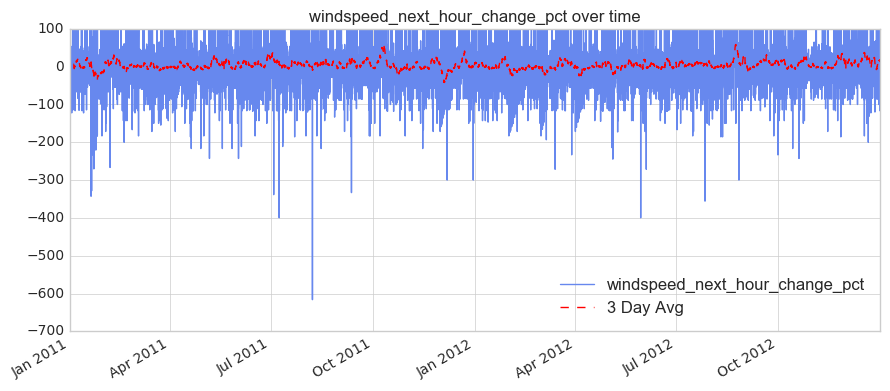

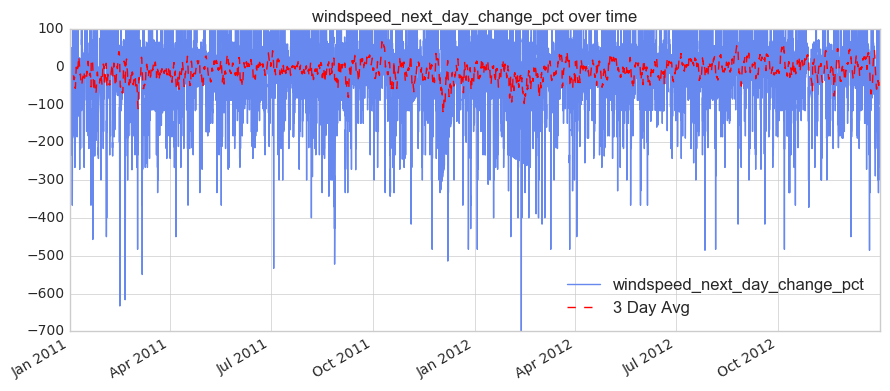

In [445]:
for col in windspeed_var_list: 
    outliers[col] = plot_with_window(col)

In [446]:
all_no_dummy.ix[unique_outliers(windspeed_var_list)][windspeed_var_list].head()

windspeed  windspeed_next_hour_change_pct  \
2011-01-09 16:00:00    30.0026                      -15.382633   
2011-01-09 17:00:00    26.0027                      -18.179050   
2011-01-13 18:00:00    22.0028                      -29.444225   
2011-01-19 21:00:00    27.9993                     -154.506699   
2011-01-19 23:00:00    31.0009                     -342.775120   

                     windspeed_next_day_change_pct  
2011-01-09 16:00:00                    -233.432614  
2011-01-09 17:00:00                    -271.387560  
2011-01-13 18:00:00                    -266.517857  
2011-01-19 21:00:00                    -366.406250  
2011-01-19 23:00:00                    -342.775120

### There are 934 values beyond out threshold in total. Let's interpolate them. 

In [447]:
len(unique_outliers(humidity_var_list + temp_var_list + atemp_var_list + windspeed_var_list + ['atemp_temp_diff']))

934

In [448]:
def interpolate_data(dataset):
    data = dataset.copy()
    for col_list in [humidity_var_list] + [temp_var_list] + [atemp_var_list] + [windspeed_var_list]:
        for col in col_list:
            for timestamp in outliers[col].index:
                data.loc[timestamp, col_list] = np.NaN
    
    # avoid first row NaN 
    data.iloc[0] = data.iloc[0].fillna(data.mean())
    data = data.interpolate(method='time')
    # after interpolating continuous varialbes we must recompute derivated variables
    data = set_derivated_vars(data)
    data = set_temp_cat(data)
    return data

In [449]:
all_no_dummy_interpolate = interpolate_data(all_no_dummy.copy())

** Difference between original and interpolated data. **

In [450]:
(all_no_dummy != all_no_dummy_interpolate).sum()

atemp                              144
casual                               0
count                                0
holiday                              0
humidity                           278
registered                           0
season                               0
temp                               121
weather                              0
windspeed                          457
workingday                           0
next_hour_weather                    0
year                                 0
month                                0
day                                  0
hour                                 0
dayofweek                            0
weekofyear                           0
season_cat                           0
month_cat                            0
dayofweek_cat                        0
weather_cat                          0
quarter                              0
bike_season                          0
temp_next_hour_change_pct          168
temp_next_day_change_pct 

** Some exmaple: **

** 2012-01-10 05:00:00  - there were outliers for temp (16.40) and atemp (20.46). Those values were interpolated to (12.77) and (15.26) respectively. **

In [451]:
all_no_dummy.loc[('2012-01-10 02:00:00'):('2012-01-10 07:00:00')][continuous_var]

temp   atemp  humidity  windspeed
2012-01-10 02:00:00   9.02  11.365        87    11.0014
2012-01-10 04:00:00   8.20  10.605        86    11.0014
2012-01-10 05:00:00  16.40  20.455        47    15.0013
2012-01-10 06:00:00   7.38   9.090        93    12.9980
2012-01-10 07:00:00   7.38   9.850        93    11.0014

In [452]:
all_no_dummy_interpolate.ix[('2012-01-10 02:00:00'):('2012-01-10 07:00:00')][continuous_var]

temp      atemp   humidity  windspeed
2012-01-10 02:00:00   9.020000  11.365000  87.000000    11.0014
2012-01-10 04:00:00   8.200000  10.605000  57.295405    11.0014
2012-01-10 05:00:00  12.768315  15.260241  47.000000    15.0013
2012-01-10 06:00:00   7.380000   9.090000  93.000000    12.9980
2012-01-10 07:00:00   7.380000   9.850000  93.000000    11.0014

___
** From the boxplot below its clear most bike rentals are  in hours: 8, 17, 18. We should expect that registred users rent bikes in those hours becouse there are almost no outliers. Between those hours there are hours with many outliers. We should expect that more casual users rent bikes in those hours  **

<function matplotlib.pyplot.tight_layout>

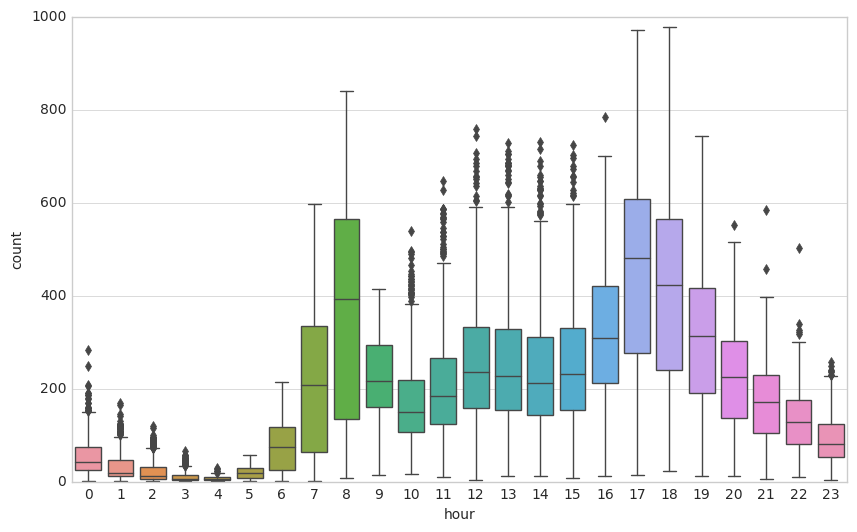

In [453]:
plt.figure(figsize=(10,6))
sns.boxplot(x="hour", y="count", data=all_no_dummy[all_no_dummy['train'] == 1])
plt.tight_layout

** On the plots below we can see rentals distribution for specifc month. Druing summer there are most demand for bikes. During all season hour-rental characteristics have the same shape: for working days thera are two peaks on 8 and 17-18 hours. Casual users rent bike usually between those hours as well as during weekends. **

<function matplotlib.pyplot.tight_layout>

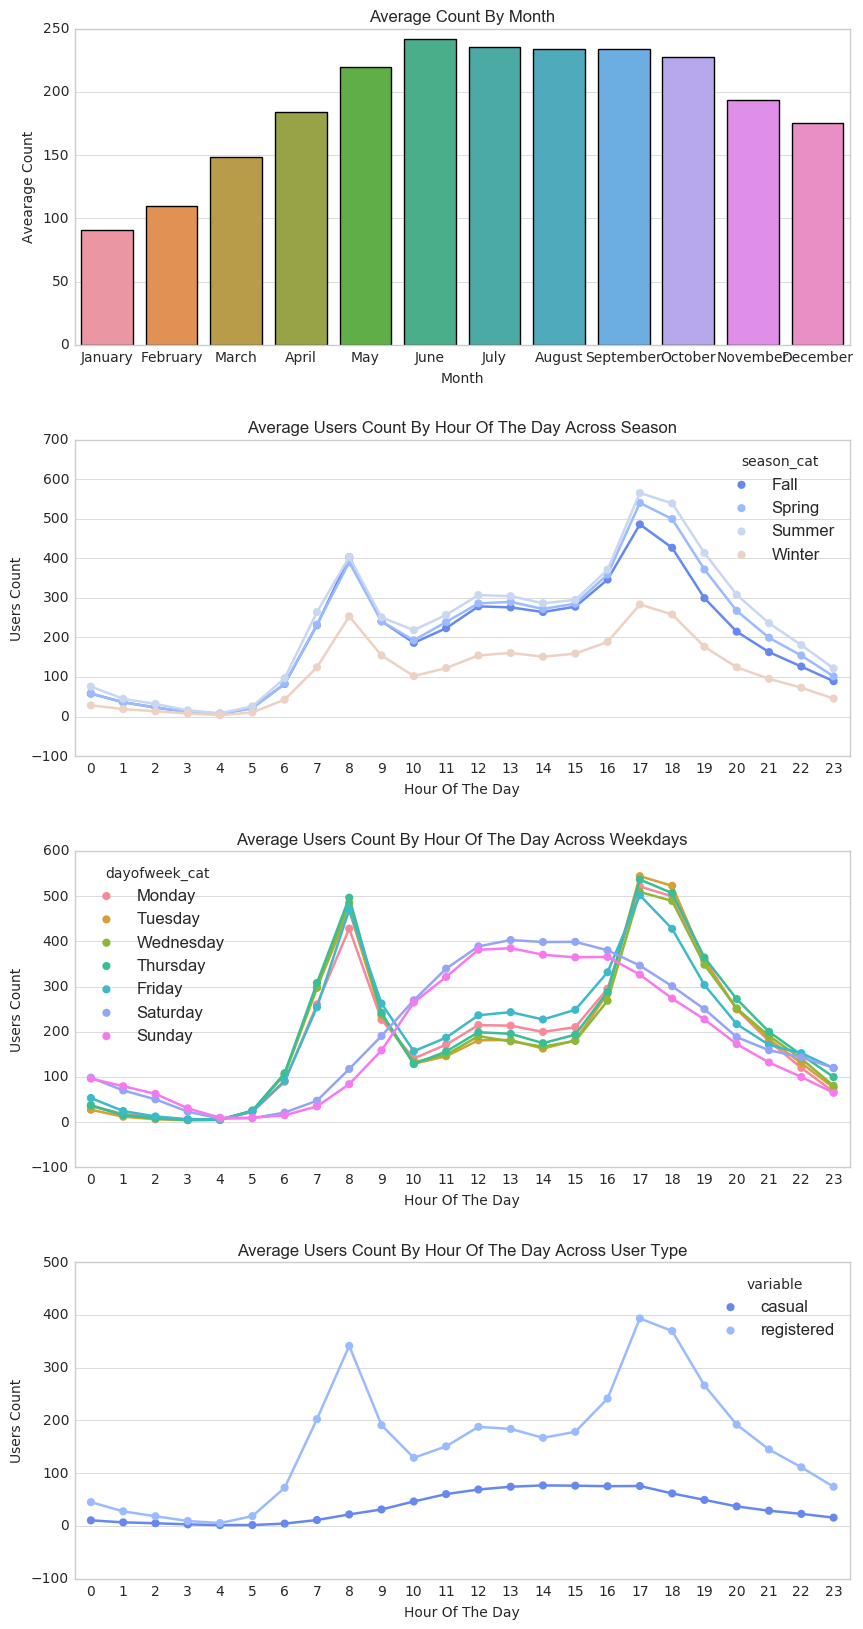

In [454]:
# below code is taken from https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4, figsize=(10,20))
#fig.set_size_inches(12,15)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

monthAggregated = pd.DataFrame(all_no_dummy[all_no_dummy['train'] == 1].groupby("month_cat")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month_cat",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(all_no_dummy[all_no_dummy['train'] == 1].groupby(["hour","season_cat"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season_cat"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(all_no_dummy[all_no_dummy['train'] == 1].groupby(["hour","dayofweek_cat"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["dayofweek_cat"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(all_no_dummy[all_no_dummy['train'] == 1][["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** There are not clear linear relationships between variables, besides dependent variables (casual, registerd, count) themselves and temp - atemp.  It indicates that machine learning regression algorithms that can handle non-linearity could perfom better than linear regression.** 

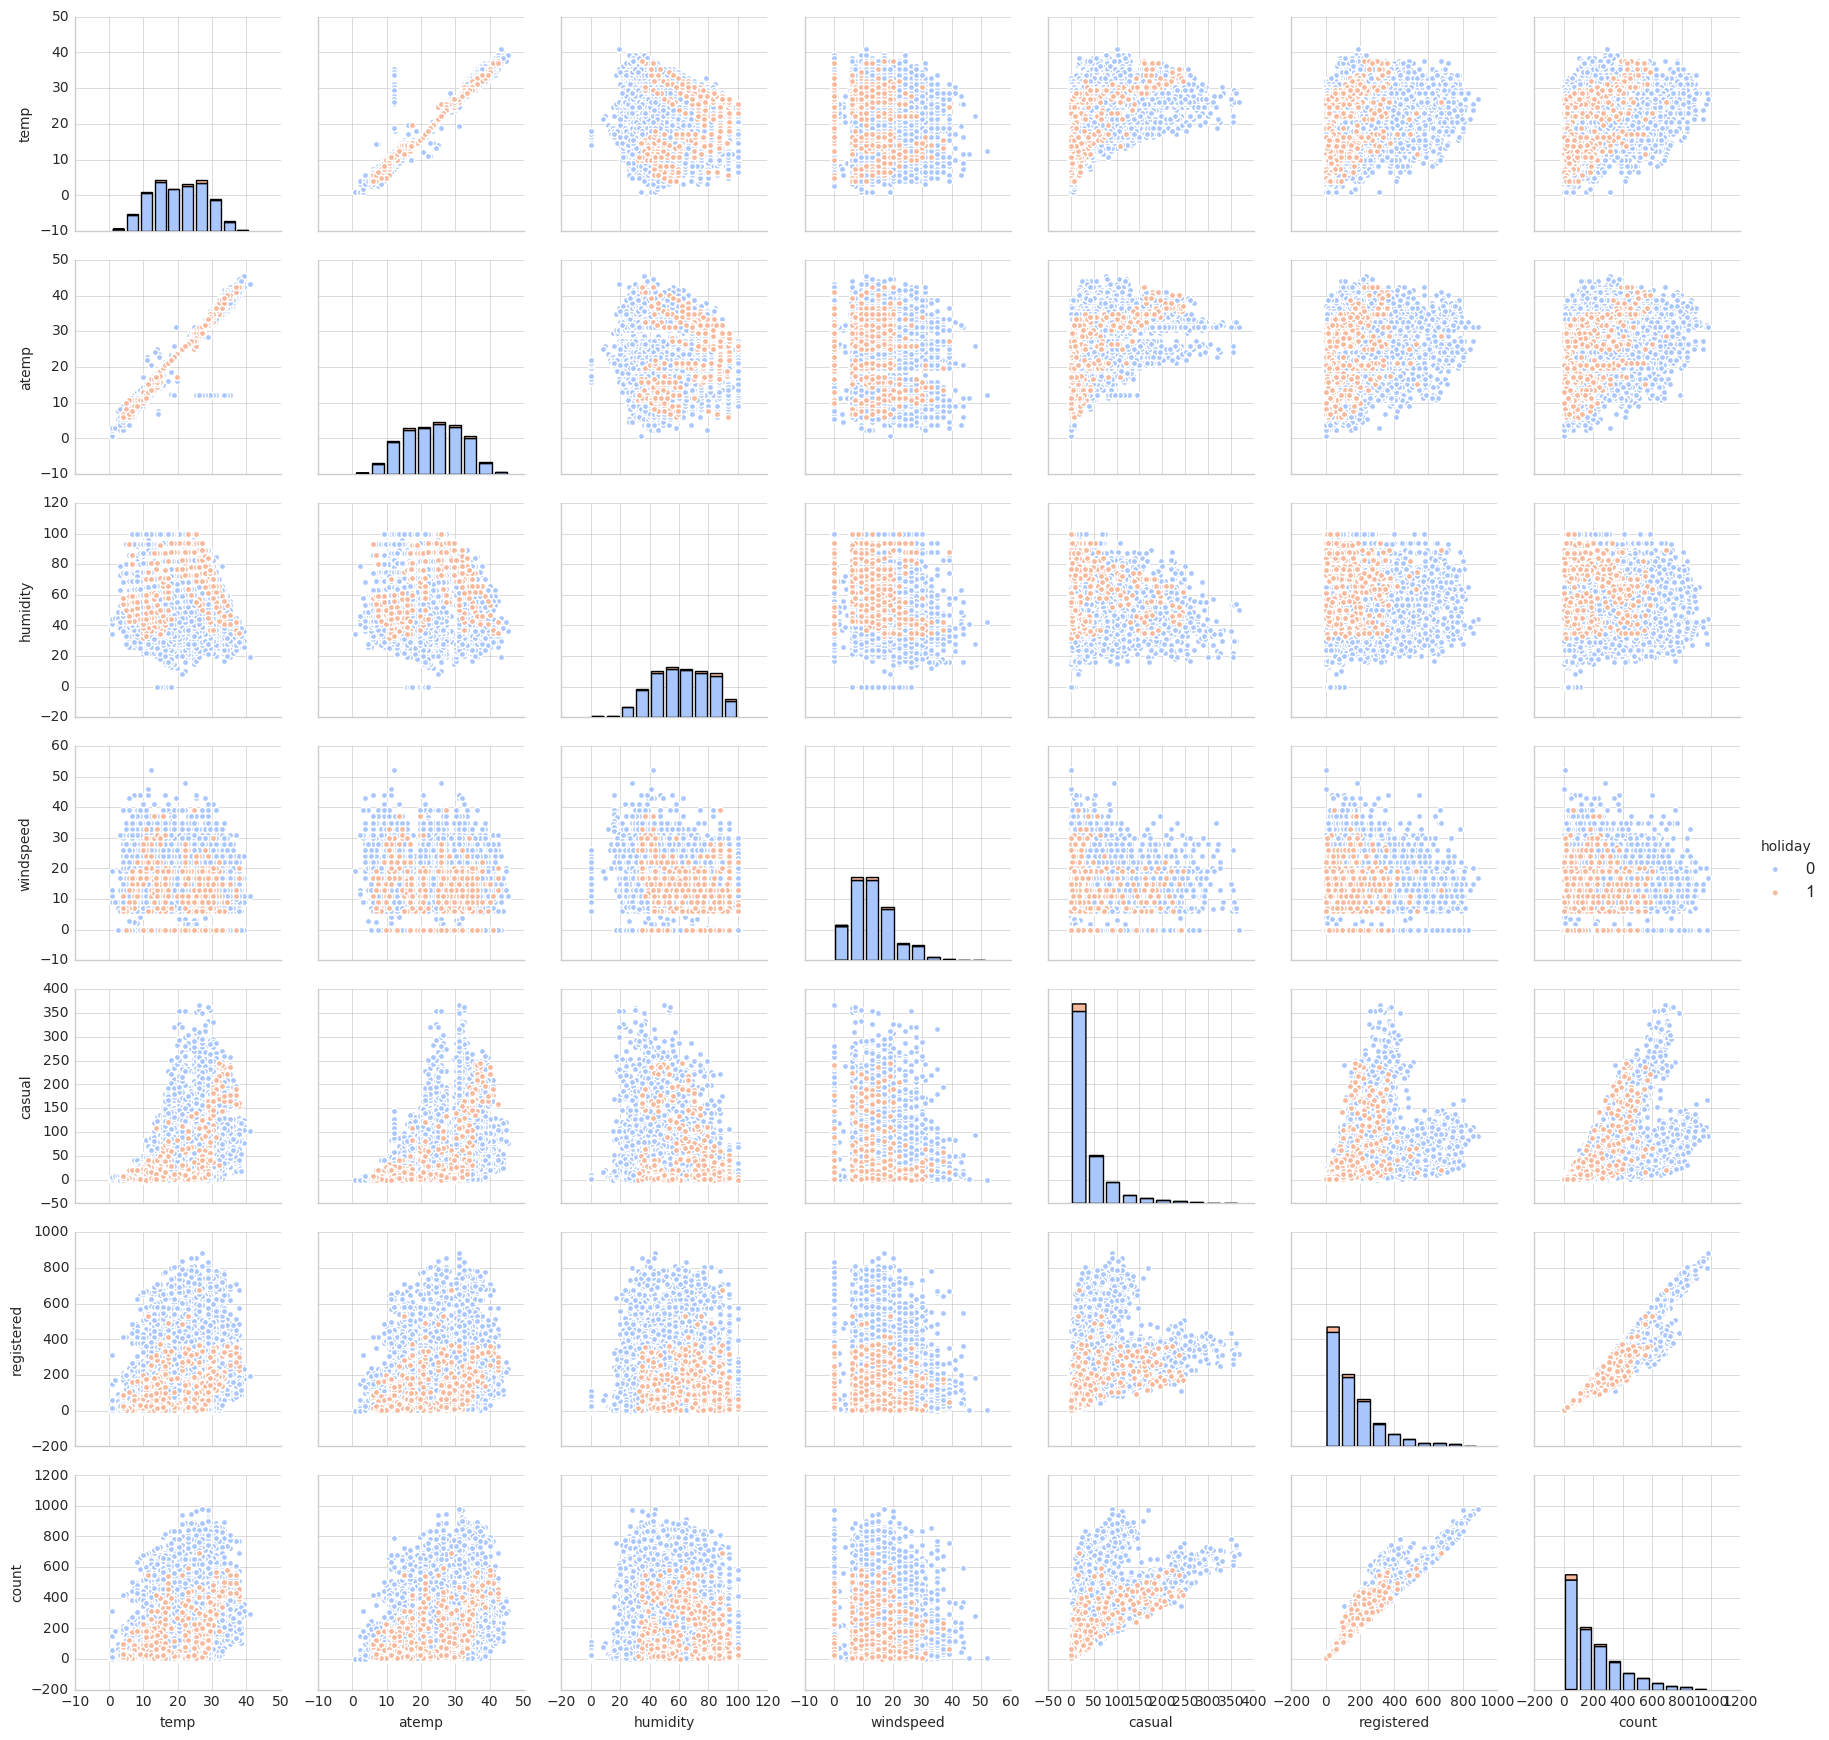

In [455]:
sns.pairplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], vars=continuous_var + dependent_variables, hue='holiday', palette='coolwarm')

** There is some correlation (showed on some next cells on heatmap) between casual and registred users rentals. **

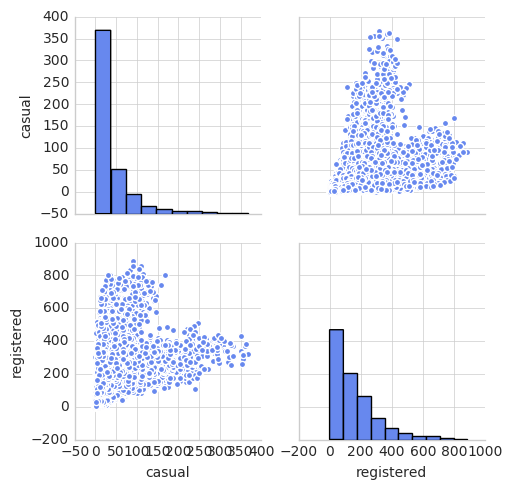

In [456]:
sns.pairplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], vars=['casual', 'registered'], palette='coolwarm')

** It's clear linear relationships between temperature in Celsius and "feels like" temperature in Celsius'. We should drop one of them to avoid <a href='https://en.wikipedia.org/wiki/Multicollinearity'> multicollinearity </a> **

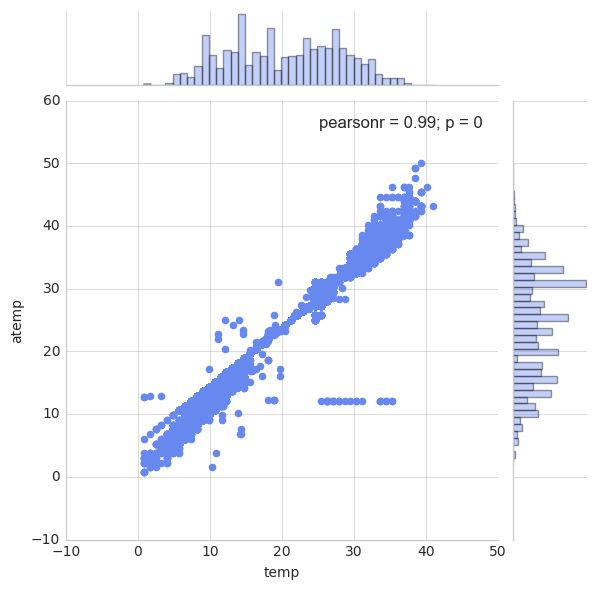

In [457]:
sns.jointplot(x='temp',y='atemp',data=all_no_dummy_interpolate)

** There are potentially 25 outliers where absolute difference between temperature in Celsius and "feels like" temperature in Celsius is greater than 5 Celsius degree. We can build another linear regression model to predict atemp for those outliers. But taking into account fact, there are only 24 records, we just simply set mean() on atemp_temp_diff variable for those records and we will drop atemp variable as well.** 

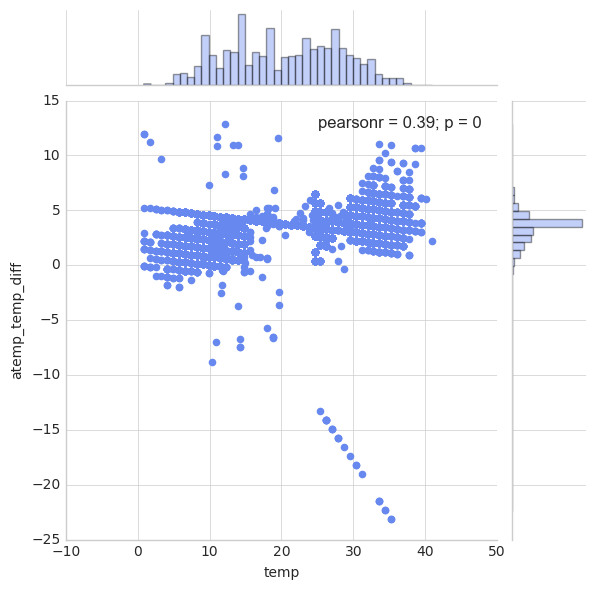

In [458]:
sns.jointplot(x='temp',y='atemp_temp_diff',data=all_no_dummy_interpolate)

In [459]:
all_no_dummy_interpolate[all_no_dummy_interpolate['atemp_temp_diff'] < -10][continuous_var + ['atemp_temp_diff']]

temp  atemp  humidity  windspeed  atemp_temp_diff
2012-08-17 00:00:00  27.88  12.12      57.0    11.0014           -15.76
2012-08-17 01:00:00  27.06  12.12      65.0     7.0015           -14.94
2012-08-17 02:00:00  27.06  12.12      61.0     8.9981           -14.94
2012-08-17 03:00:00  26.24  12.12      65.0     7.0015           -14.12
2012-08-17 04:00:00  26.24  12.12      73.0    11.0014           -14.12
2012-08-17 05:00:00  26.24  12.12      73.0     7.0015           -14.12
2012-08-17 06:00:00  25.42  12.12      78.0     8.9981           -13.30
2012-08-17 07:00:00  26.24  12.12      73.0     7.0015           -14.12
2012-08-17 08:00:00  27.88  12.12      65.0     8.9981           -15.76
2012-08-17 09:00:00  28.70  12.12      58.0     7.0015           -16.58
2012-08-17 10:00:00  30.34  12.12      55.0    11.0014           -18.22
2012-08-17 11:00:00  31.16  12.12      52.0    19.0012           -19.04
2012-08-17 12:00:00  33.62  12.12      41.0    15.0013           -21.50
2012-08-17 13:00:00  34.44  12.12      36.0    26.0027           -22.32
2012-08-17 14:00:00  35.26  12.12      34.0    27.9993           -23.14
2012-08-17 15:00:00  35.26  12.12      30.0    31.0009           -23.14
2012-08-17 16:00:00  34.44  12.12      32.0    30.0026           -22.32
2012-08-17 17:00:00  33.62  12.12      36.0    22.0028           -21.50
2012-08-17 18:00:00  33.62  12.12      38.0    16.9979           -21.50
2012-08-17 19:00:00  30.34  12.12      55.0    26.0027           -18.22
2012-08-17 20:00:00  29.52  12.12      58.0    15.0013           -17.40
2012-08-17 21:00:00  27.88  12.12      69.0    19.9995           -15.76
2012-08-17 22:00:00  27.06  12.12      83.0    12.9980           -14.94
2012-08-17 23:00:00  26.24  12.12      83.0    15.0013           -14.12

In [460]:
all_no_dummy_interpolate.loc[all_no_dummy_interpolate['atemp_temp_diff'] < -10 , \
                             ['atemp','atemp_temp_diff']] = np.NaN
all_no_dummy.loc[all_no_dummy['atemp_temp_diff'] < -10 , \
                             ['atemp','atemp_temp_diff']] = np.NaN
all_no_dummy_interpolate = all_no_dummy_interpolate.interpolate(method='time')
all_no_dummy = all_no_dummy.interpolate(method='time')
all_no_dummy_interpolate = set_derivated_vars(all_no_dummy_interpolate)
all_no_dummy = set_derivated_vars(all_no_dummy)

** Right now there are no outliers for atemp_temp_diff variable. **

In [461]:
all_no_dummy_interpolate[all_no_dummy_interpolate['atemp_temp_diff'] < -10][continuous_var + ['atemp_temp_diff']]

Empty DataFrame
Columns: [temp, atemp, humidity, windspeed, atemp_temp_diff]
Index: []

___
### Compare categorical variables distribution across Train and Test datasets

** TRAIN data set - categorical variables. **

<function matplotlib.pyplot.tight_layout>

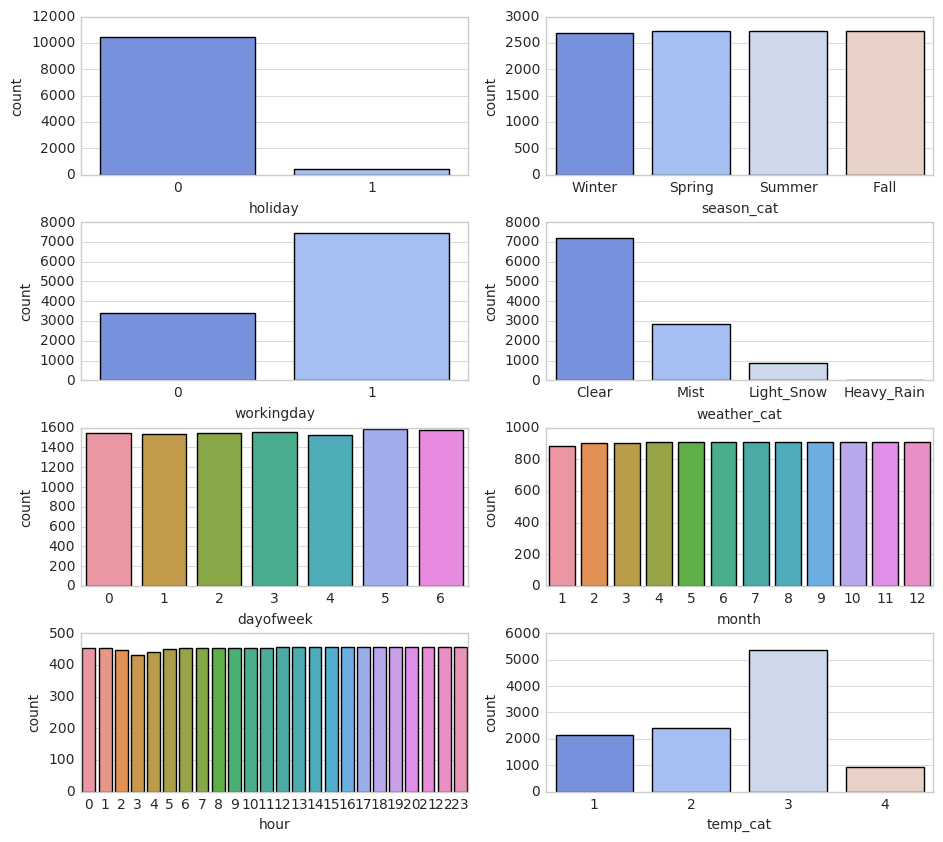

In [462]:
fig,axes= plt.subplots(nrows=4, ncols=2, figsize=(11,10))

sns.countplot(x='holiday',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[0][0])
sns.countplot(x='season_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[0][1])
sns.countplot(x='workingday',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[1][0])
sns.countplot(x='weather_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[1][1])
sns.countplot(x='dayofweek',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[2][0])
sns.countplot(x='month',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[2][1])
sns.countplot(x='hour',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[3][0])
sns.countplot(x='temp_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], ax=axes[3][1])
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** TEST data set - categorical variables. **

<function matplotlib.pyplot.tight_layout>

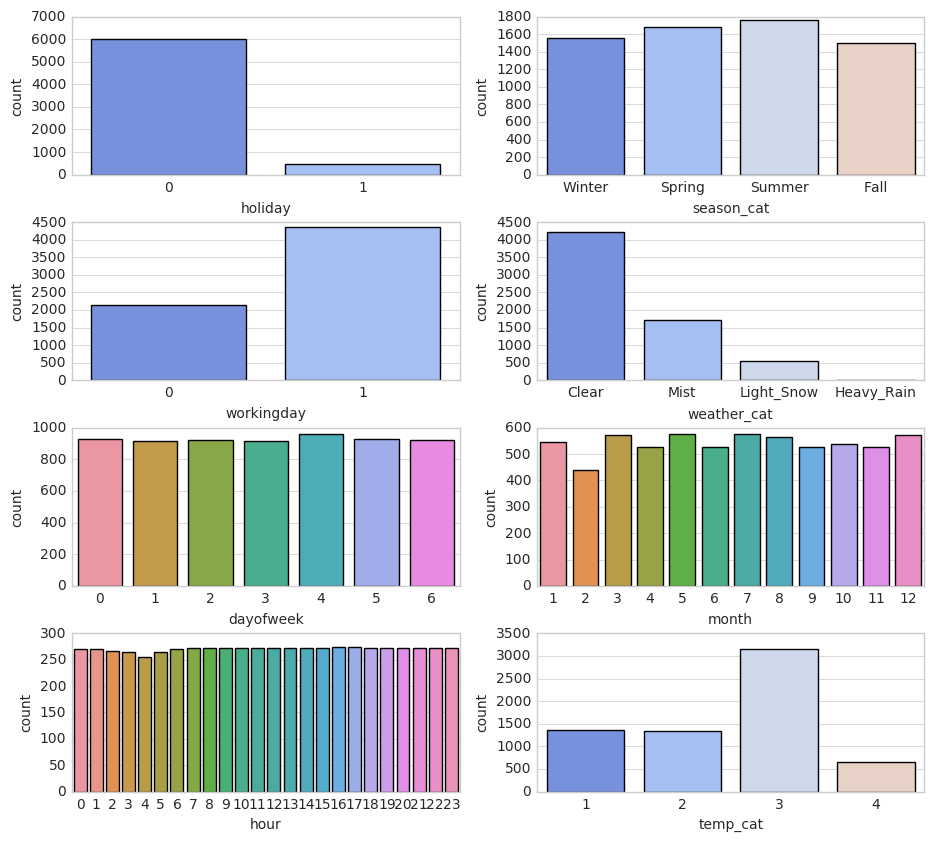

In [463]:
fig,axes= plt.subplots(nrows=4, ncols=2, figsize=(11,10))

sns.countplot(x='holiday',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[0][0])
sns.countplot(x='season_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[0][1])
sns.countplot(x='workingday',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[1][0])
sns.countplot(x='weather_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[1][1])
sns.countplot(x='dayofweek',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[2][0])
sns.countplot(x='month',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[2][1])
sns.countplot(x='hour',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[3][0])
sns.countplot(x='temp_cat',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1], ax=axes[3][1])
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** Mainly difference between Train and Test caterogical variables distribution is a smaller amount of rows in February for test data set - it's due to fact in 2011 February had 28 days and in 2012 had 29 days. **

### Compare continuous variables distribution across Train and Test datasets

** TRAIN data set - continuous variables. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


<function matplotlib.pyplot.tight_layout>

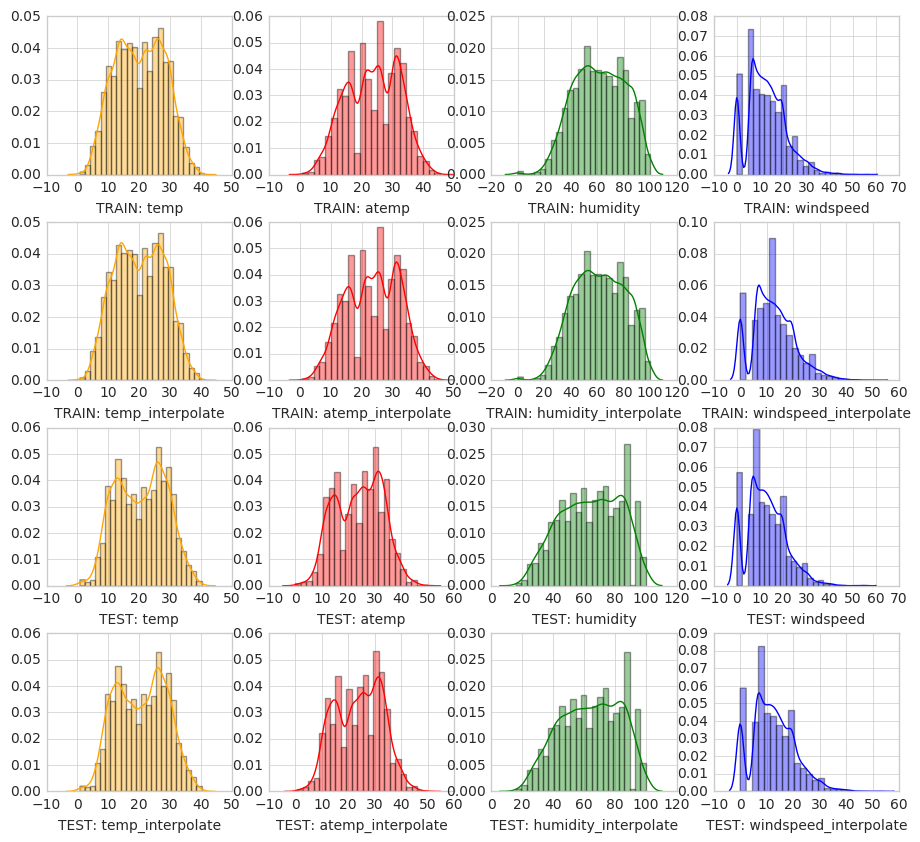

In [479]:
fig,axes= plt.subplots(nrows=4, ncols=4, figsize=(11,10))

sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['temp'], bins=24, ax=axes[0][0], axlabel='TRAIN: temp', color='orange')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1]\
             ['temp'], bins=24, ax=axes[1][0], axlabel='TRAIN: temp_interpolate', color='orange')
sns.distplot(all_no_dummy[all_no_dummy['train'] != 1]['temp'], bins=24, ax=axes[2][0], axlabel='TEST: temp', color='orange')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1]\
             ['temp'], bins=24, ax=axes[3][0], axlabel='TEST: temp_interpolate', color='orange')

sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['atemp'], bins=24, ax=axes[0][1], axlabel='TRAIN: atemp', color='red')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1]\
             ['atemp'], bins=24, ax=axes[1][1], axlabel='TRAIN: atemp_interpolate', color='red')
sns.distplot(all_no_dummy[all_no_dummy['train'] != 1]['atemp'], bins=24, ax=axes[2][1], axlabel='TEST: atemp', color='red')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1]\
             ['atemp'], bins=24, ax=axes[3][1], axlabel='TEST: atemp_interpolate', color='red')


sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['humidity'], bins=24, ax=axes[0][2], axlabel='TRAIN: humidity', color='green')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1]\
             ['humidity'], bins=24, ax=axes[1][2], axlabel='TRAIN: humidity_interpolate', color='green')
sns.distplot(all_no_dummy[all_no_dummy['train'] != 1]['humidity'], bins=24, ax=axes[2][2], axlabel='TEST: humidity', color='green')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1]\
             ['humidity'], bins=24, ax=axes[3][2], axlabel='TEST: humidity_interpolate', color='green')

sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['windspeed'], bins=24, ax=axes[0][3], axlabel='TRAIN: windspeed', color='blue')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1]\
             ['windspeed'], bins=24, ax=axes[1][3], axlabel='TRAIN: windspeed_interpolate', color='blue')
sns.distplot(all_no_dummy[all_no_dummy['train'] != 1]['windspeed'], bins=24, ax=axes[2][3], axlabel='TEST: windspeed', color='blue')
sns.distplot(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1]\
             ['windspeed'], bins=24, ax=axes[3][3], axlabel='TEST: windspeed_interpolate', color='blue')

plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** We can see that both TRAIN and TEST data sets have very similar distribution for continuous variablers so overall there is no need to  select specific subset from training data to train models on. **

___
### Mesure correlation between variables.

In [465]:
all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].corr().ix[dependent_variables]

atemp    casual     count   holiday  humidity  registered  \
casual      0.465295  1.000000  0.690414  0.024455 -0.345447    0.497250   
registered  0.317091  0.497250  0.970948 -0.041725 -0.263658    1.000000   
count       0.392722  0.690414  1.000000 -0.028046 -0.315115    0.970948   

              season      temp   weather  windspeed  workingday  \
casual      0.096758  0.467454 -0.135918   0.091239   -0.319864   
registered  0.164011  0.319079 -0.109340   0.091687    0.120154   
count       0.163439  0.394975 -0.128655   0.101613    0.011965   

            next_hour_weather      year     month       day      hour  \
casual              -0.121850  0.145241  0.092722  0.014109  0.302045   
registered          -0.098727  0.264265  0.169451  0.019111  0.380540   
count               -0.115926  0.260403  0.166862  0.019826  0.400601   

            dayofweek  weekofyear   quarter  bike_season  \
casual       0.246959    0.079906  0.174336     0.286533   
registered  -0.084427    0.156480  0.311324     0.185317   
count       -0.002283    0.152512  0.307666     0.233545   

            temp_next_hour_change_pct  temp_next_day_change_pct  \
casual                       0.016448                  0.022116   
registered                   0.024369                  0.008600   
count                        0.024856                  0.013270   

            atemp_next_hour_change_pct  atemp_next_day_change_pct  \
casual                        0.015504                   0.021610   
registered                    0.023279                   0.015783   
count                         0.023686                   0.019120   

            humidity_next_hour_change_pct  humidity_next_day_change_pct  \
casual                          -0.016336                      0.085329   
registered                       0.002576                      0.045275   
count                           -0.002358                      0.061284   

            windspeed_next_hour_change_pct  windspeed_next_day_change_pct  \
casual                           -0.000753                       0.031184   
registered                       -0.026705                       0.006744   
count                            -0.022474                       0.014224   

            atemp_temp_diff  temp_cat  hour_cat  train  casual_log  casual_bc  \
casual             0.230798  0.216121  0.065176    NaN    0.780839   0.831148   
registered         0.154153  0.305970  0.215257    NaN    0.629648   0.617549   
count              0.192189  0.314726  0.197458    NaN    0.740363   0.744150   

            casual_cat  registered_log  registered_bc  registered_cat  \
casual        0.832119        0.510717       0.485741        0.485506   
registered    0.617976        0.805086       0.842076        0.841967   
count         0.744773        0.812142       0.836096        0.835941   

            count_log  count_bc  count_cat  
casual       0.579034  0.601466   0.601483  
registered   0.792129  0.884853   0.884706  
count        0.820181  0.903682   0.903563

** Heatmap is better visualisation tool to see some Pearson Correlation. There aren't strong correlations: hour and temp variable have approximately 0.4 Pearson Correlation value. **

<function matplotlib.pyplot.tight_layout>

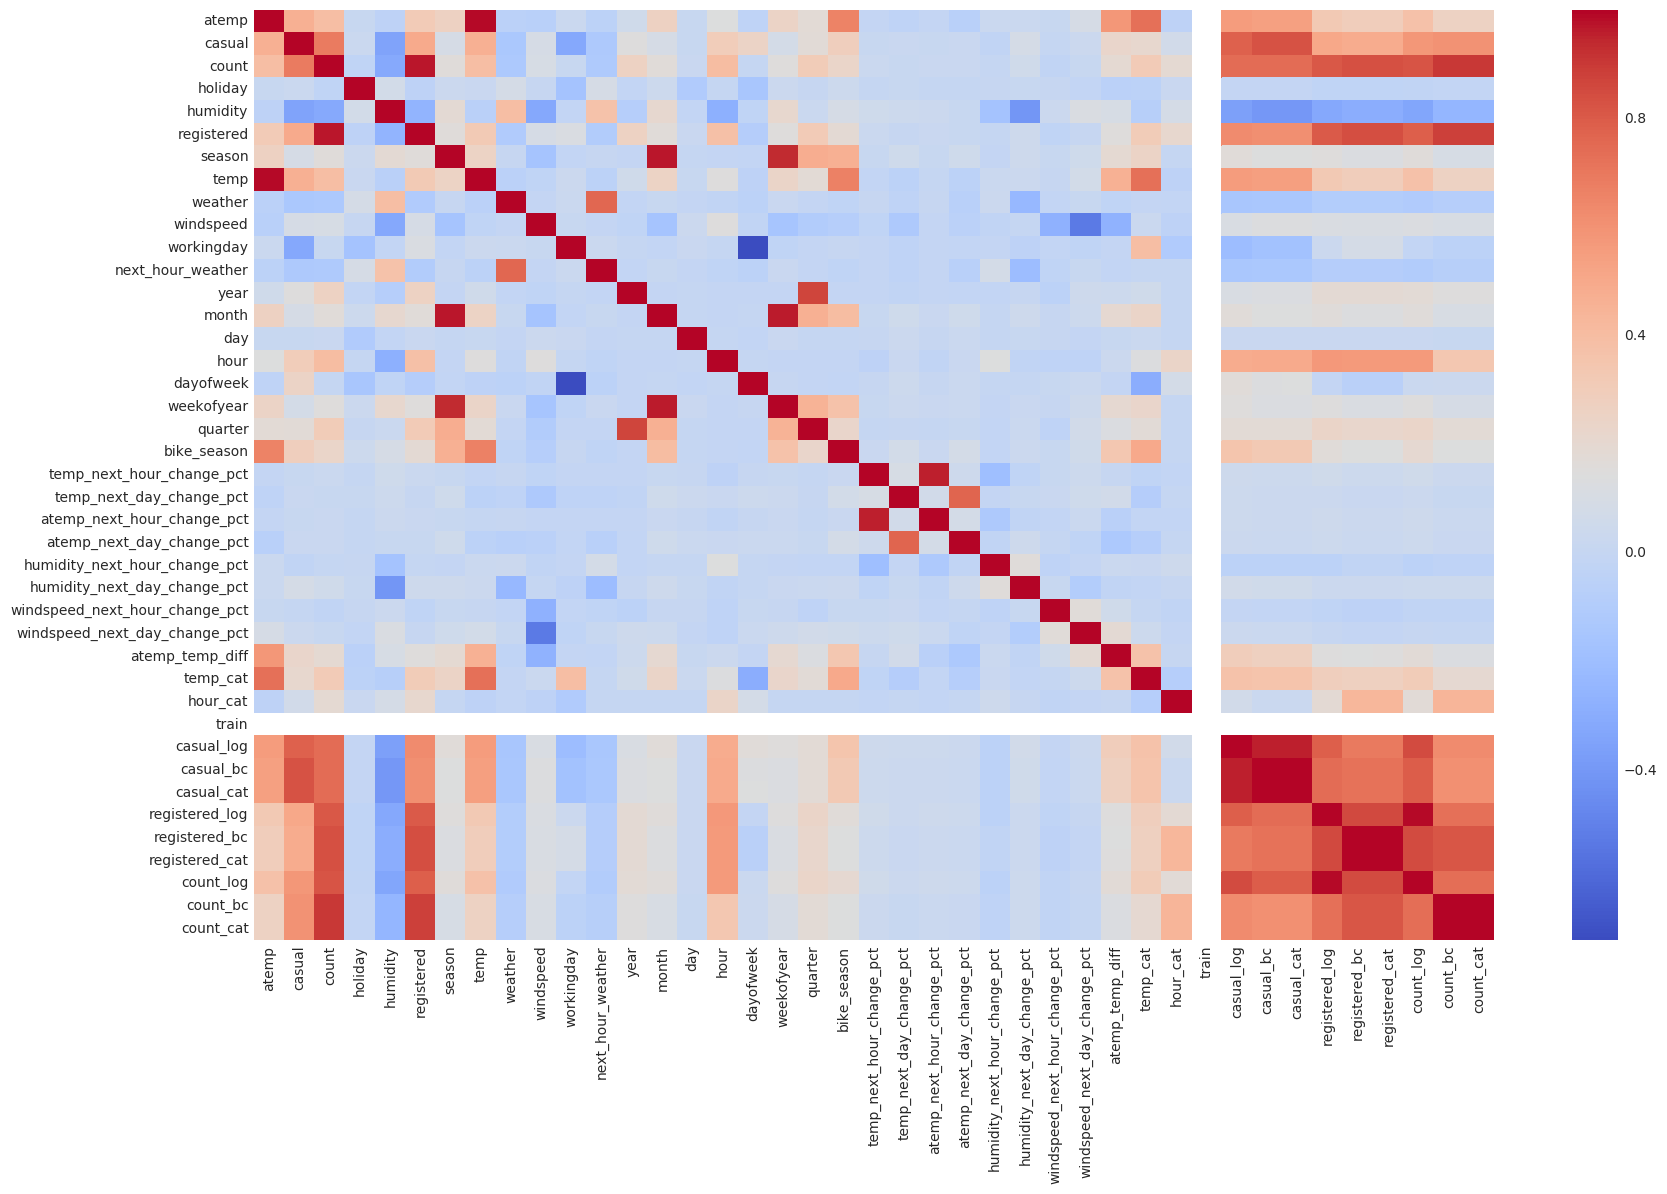

In [466]:
fig = plt.figure(figsize=(20,12))
sns.heatmap(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].corr(), annot=False,cmap='coolwarm')
plt.tight_layout

** We can see that linear regression can give us only roughly approximation of total rentals from hour variable. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


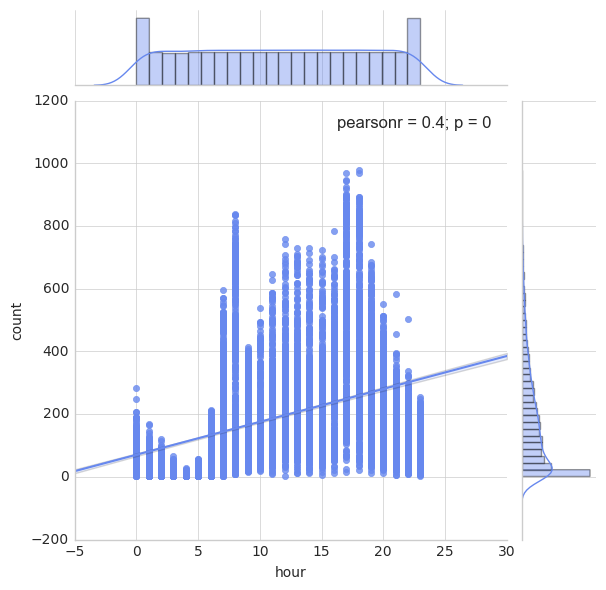

In [467]:
sns.jointplot(x='hour',y='count',kind='reg',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1])

** Temp-Count scatter plot is skewed in right direction which indicates that higher temperature results in higher total bike rentals. But again, we can see it's only roughly approximation. **

/Users/suchy/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


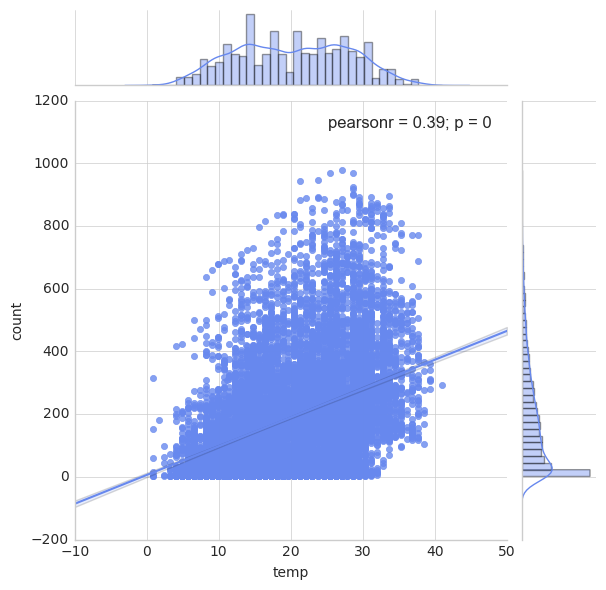

In [468]:
sns.jointplot(x='temp',y='count',kind='reg',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1])

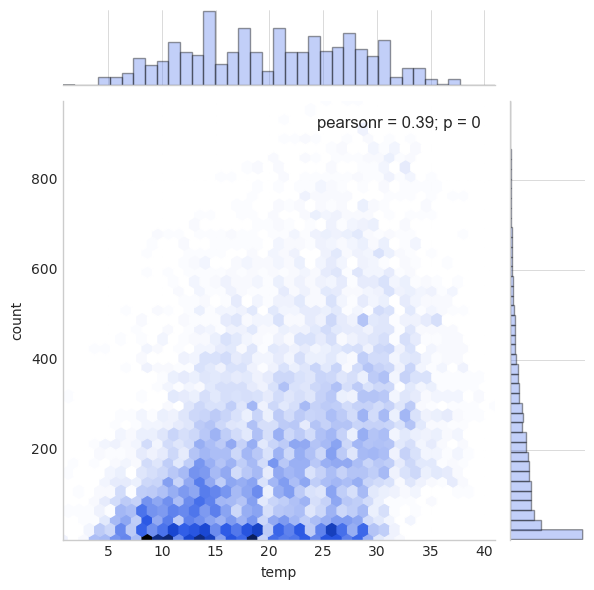

In [469]:
sns.jointplot(x='temp',y='count',kind='hex',data=all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1])

** Let's have a close look on ditribution across different years. **

In [470]:
train_no_dummy_year_piv = all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].pivot_table(values='count',index='month',columns='year').rename(index=monthDict)
train_no_dummy_year_piv

year             2011        2012
month                            
January     54.645012  124.353201
February    73.641256  145.646154
March       86.849776  208.276923
April      111.026374  257.455947
May        174.809211  264.109649
June       196.877193  287.186404
July       203.614035  267.037281
August     182.666667  285.570175
September  174.622517  292.598684
October    174.773626  280.508772
November   155.458333  231.980220
December   134.173246  217.054825

** It looks like there are much more rentals in 2012 than in 2011. Perhaps there were more bikes to rent in 2012 than in 2011. Another reason could be fact that people got used to rent a bike from Capital BikeShare and there were more registred users in total. **

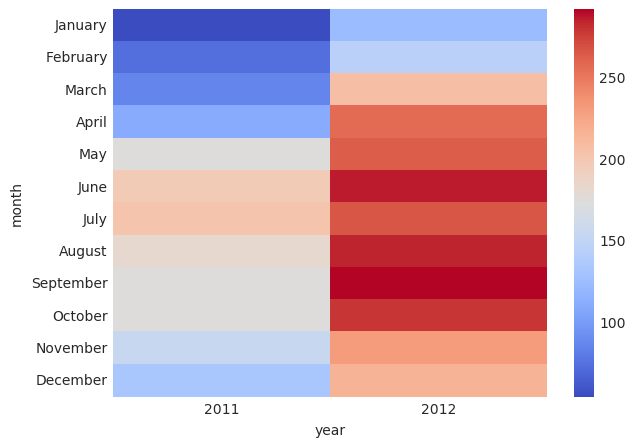

In [471]:
fig = plt.figure(figsize=(7,5))
sns.heatmap(train_no_dummy_year_piv,cmap='coolwarm')

In [472]:
train_no_dummy_month_piv = all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].pivot_table(values='count',index='hour',columns='month').rename(columns=monthDict)

** We can see that from April to November there is a bike season.  **

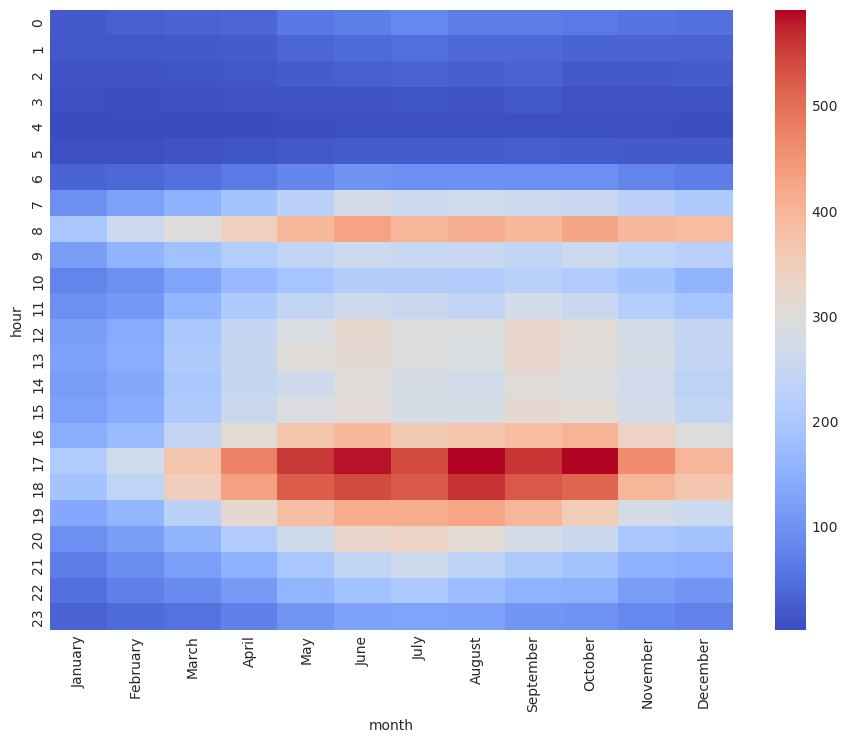

In [473]:
fig = plt.figure(figsize=(11,8))
sns.heatmap(train_no_dummy_month_piv,cmap='coolwarm')

In [474]:
train_no_dummy_workingday_piv = all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].pivot_table(values='count_cat',index='hour',columns=['workingday'])

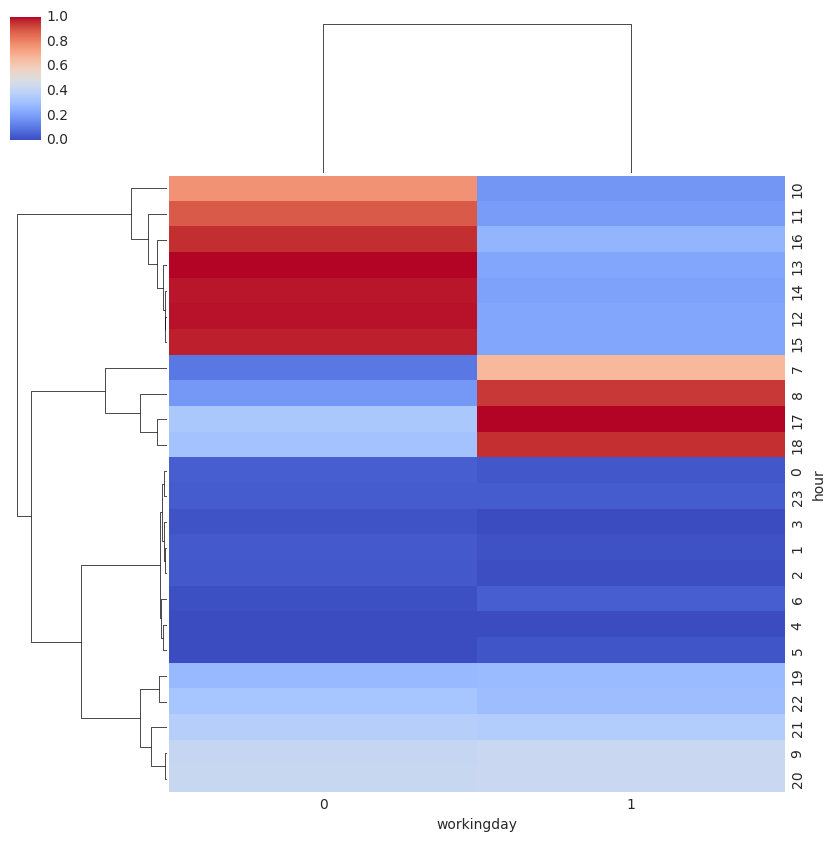

In [475]:
sns.clustermap(train_no_dummy_workingday_piv,cmap='coolwarm',standard_scale=1,method='average')

** From the plot clustermap above we can devide hours into 4 categories: **
<ol> 
<li>Dusk and dawn
    <ul>
        <li>(0-6) + 23</li>
    </ul>
</li>

<li>Traffic peak
    <ul>
        <li>(7-8), workingday = 1</li>
        <li>(10-16), workingday = 0</li>
        <li>(17-18), workingday = 1</li>
    </ul>
</li>

<li>Evening and works begin
    <ul>
        <li>(19-22) + 9</li>
    </ul>
</li>

<li>Rest

</li>

</ol>
</ol>
We added those categories in variable **hour_cat.**

In [476]:
train_no_dummy_year_temp_piv = all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1].round().pivot_table(values='count_cat',index='temp',columns=['workingday']).dropna()

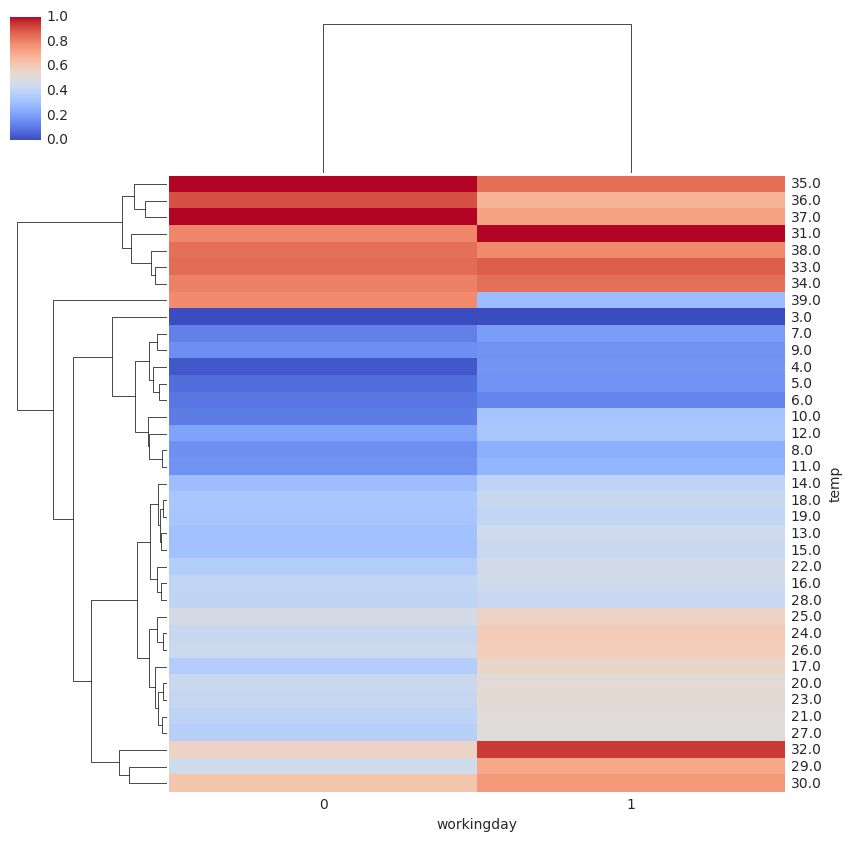

In [477]:
sns.clustermap(train_no_dummy_year_temp_piv,cmap='coolwarm',standard_scale=1,method='average')

** From the plot clustermap above we can devide rounded temp into 3 categories: **
<ol>
<li>(below 13)</li>
<li>[13-30], workingday=0</li>
<li>[13-30], workingday=1</li>
<li>(above 30)</li>
</ol>

We added those categories in variable ** temp_cat. **

___
# 4. Training and Testing Data
----
###  4.1 Regression Evaluation Metrics

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

**Root Mean Squared Log Error** (RMSLE) is the square root of the mean of the squared log errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(log(y_i+1)-log(\hat{y}_i+1))^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.
- **RMSLE** can be used when we don’t want to penalize huge differences when both the values are huge numbers.

All of these are **loss functions**, because we want to minimize them.
___

In [78]:
def evaluatorMAE_own(predictions, labelCol):
    diff = np.abs(predictions[labelCol] - predictions['prediction'])
    mean_error = diff.mean()
    return mean_error

def evaluatorMSE_own(predictions, labelCol):
    diff = predictions[labelCol] - predictions['prediction']
    mean_error = np.square(diff).mean()
    return mean_error
                                   
def evaluatorRMSE_own(predictions, labelCol):
    diff = predictions[labelCol] - predictions['prediction']
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

def evaluatorRMSLE_own(predictions, labelCol):
    diff = np.log(predictions[labelCol] + 1) - np.log(predictions['prediction'] + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

def evaluatorR2_own(predictions, labelCol):
    SS_res = np.sum(np.square(predictions[labelCol] - predictions['prediction']))
    SS_tot = np.sum(np.square(predictions[labelCol] - predictions[labelCol].mean()))
    R2 = 1 - SS_res/SS_tot
    return R2

def undo_log_transform(pred,labelCol, Kaggle=False):
    predictions = pred.copy()
    # Kaggle test data doesn't have labels
    if (not Kaggle):
        predictions[labelCol] = np.exp(predictions[labelCol]) - 1
    predictions['prediction'] = np.exp(predictions['prediction']) - 1
    return predictions
                                   
def evaluateMetrics(preds, labelCol, rollback=True, rounded=True):   
    predictions = preds.copy()
    
    if (rollback):
        predictions = undo_log_transform(predictions, labelCol)
    if (rounded):
        predictions = np.round(predictions)
    
    print("MAE:   " + str('%.4f' % evaluatorMAE_own(predictions, labelCol)))
    print("MSE:   " + str('%.4f' % evaluatorMSE_own(predictions, labelCol)))
    print("RMSE:  " + str('%.4f' % evaluatorRMSE_own(predictions, labelCol)))
    print("R2:    " + str('%.4f' % evaluatorR2_own(predictions, labelCol)))
    print("----------------")
    print("RMSLE: " + str('%.4f' % evaluatorRMSLE_own(predictions, labelCol)))
    print("----------------")
    
    return evaluatorRMSLE_own(predictions, labelCol)

** Drop unnecessary added category variables from training dataset. Apache Spark needs all data to be numerical. Later on we will perform feature selection to chose best variables for our models. **

In [79]:
all_no_dummy_interpolate = all_no_dummy_interpolate.drop(added_cat_var, axis=1)

In [80]:
all_dummy_interpolate = pd.get_dummies(data = all_no_dummy_interpolate.copy(), \
                             columns = categorical_var, drop_first=True)

** Split trainind data into train and "test" to evaluate our models. Final model will predict labels for test_KAGGLE datasets. **

In [81]:
from sklearn.model_selection import train_test_split

train_dummy = all_dummy_interpolate[all_dummy_interpolate['train'] == 1]
(trainingData_dummy, testData_dummy) = train_test_split(train_dummy, test_size=0.2, random_state=101)

(trainingData_no_dummy, testData_no_dummy) = \
train_test_split(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] == 1], test_size=0.2, random_state=101)

** Create Apache Spark Data Frames ** 

In [82]:
spark_train_dummy = sqlContext.createDataFrame(trainingData_dummy)
spark_test_dummy = sqlContext.createDataFrame(testData_dummy)

spark_train_no_dummy = sqlContext.createDataFrame(trainingData_no_dummy)
spark_test_no_dummy = sqlContext.createDataFrame(testData_no_dummy)

** Prepare Kaggle test data. **

In [83]:
test_dummy = all_dummy_interpolate[all_dummy_interpolate['train'] != 1]

# reset index for including datetime as column
spark_Kaggle_test_dummy = sqlContext.createDataFrame(test_dummy.reset_index())
spark_Kaggle_test_no_dummy = sqlContext.createDataFrame(all_no_dummy_interpolate[all_no_dummy_interpolate['train'] != 1].reset_index())

___
## 4.2 Format input data for machine learning
** Apache Spark Machine Learning lib requires input as data frame transformed to labeled point. **

In [ ]:
from pyspark.ml.linalg import Vectors
DUMMY = True

In [ ]:
columns_to_hide = added_cat_var + dependent_variables + dependent_variables_log \
                + dependent_variables_cat + ['train','index']

In [ ]:
dummy_cols = [x for x in spark_train_dummy.columns if x not in columns_to_hide]
no_dummy_cols = [x for x in spark_train_no_dummy.columns if x not in columns_to_hide]

In [ ]:
def transformToLabeledPoint(row) :
    retArray=[]
    if (DUMMY):
        spark_col = dummy_cols
    else:
        spark_col = no_dummy_cols
    
    for col in spark_col:
        retArray.append(row[col])
        
    label_count = row["count_log"]
    label_registered = row["registered_log"]
    label_casual = row["casual_log"]
        
    return label_count, label_registered, label_casual, Vectors.dense(retArray)

In [ ]:
def transformToLabeledPointKaggle(row) :
    retArray=[]
    if (DUMMY):
        spark_col = dummy_cols
    else:
        spark_col = no_dummy_cols
    
    for col in spark_col:
        retArray.append(row[col])
        
    datetime = row["index"]
    
    # lables must match this from transformToLabeledPoint for further unionAll() operation    
    return datetime,0,0, Vectors.dense(retArray)

In [ ]:
def transformToLabeledPointChiSqSelector(row) :
    retArray=[]
    if (DUMMY):
        spark_col = dummy_cols
    else:
        spark_col = no_dummy_cols
    
    for col in spark_col:
        retArray.append(row[col])
        
    label_count_cat = row["count_cat"]
    label_registered_cat = row["registered_cat"]
    label_casual_cat = row["casual_cat"]
   
    return label_count_cat, label_registered_cat, label_casual_cat, Vectors.dense(retArray)

** Preparation Apache Spark data frame for linear regression **

In [ ]:
DUMMY = True
trainingData_dummy = sqlContext.createDataFrame(spark_train_dummy.rdd.map(transformToLabeledPoint), ["label_count", "label_registered", "label_casual", "features_to_filter"])
testData_dummy = sqlContext.createDataFrame(spark_test_dummy.rdd.map(transformToLabeledPoint), ["label_count", "label_registered", "label_casual", "features_to_filter"])
testKaggle_dummy = sqlContext.createDataFrame(spark_Kaggle_test_dummy.rdd.map(transformToLabeledPointKaggle), ["label_count", "label_registered", "label_casual", "features_to_filter"])
chiSq_dummy = sqlContext.createDataFrame(spark_train_dummy.unionAll(spark_test_dummy)\
                                         .rdd.map(transformToLabeledPointChiSqSelector), ["label_count_cat", "label_registered_cat", "label_casual_cat", "features_to_filter"])

** Preparation Apache Spark data frame for random forest and gradient boosted regression. No need for dummy variables. **

In [ ]:
DUMMY = False
trainingData_no_dummy = sqlContext.createDataFrame(spark_train_no_dummy.rdd.map(transformToLabeledPoint), ["label_count", "label_registered", "label_casual", "features_to_filter"])
testData_no_dummy = sqlContext.createDataFrame(spark_test_no_dummy.rdd.map(transformToLabeledPoint), ["label_count", "label_registered", "label_casual", "features_to_filter"])
testKaggle_no_dummy = sqlContext.createDataFrame(spark_Kaggle_test_no_dummy.rdd.map(transformToLabeledPointKaggle), ["label_count", "label_registered", "label_casual","features_to_filter"])
chiSq_no_dummy = sqlContext.createDataFrame(spark_train_no_dummy.unionAll(spark_test_no_dummy)\
                                         .rdd.map(transformToLabeledPointChiSqSelector), ["label_count_cat", "label_registered_cat", "label_casual_cat", "features_to_filter"])

** Cache spark data frames into memory for faster computation **

In [ ]:
trainingData_dummy.cache()
trainingData_dummy.count()
trainingData_no_dummy.cache()
trainingData_no_dummy.count()

In [ ]:
testData_dummy.cache()
testData_dummy.count()
testData_no_dummy.cache()
testData_no_dummy.count()

In [ ]:
testKaggle_dummy.cache()
testKaggle_dummy.count()
testKaggle_no_dummy.cache()
testKaggle_no_dummy.count()

** To treat categorical variables as nominal we must first index them by featureIndexer. Features with number of unique values above maxCategories will be treated as continuous. **

In [ ]:
from pyspark.ml.feature import VectorIndexer

featureIndexer =\
    VectorIndexer(inputCol="features_to_filter", outputCol="indexedFeatures", maxCategories=4) \
    .fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))

** Use ChiSquare Selector ( https://en.wikipedia.org/wiki/Chi-squared_test ) to choose best features to our models. **

In [ ]:
feature_selector_dummy = {}
feature_selector_no_dummy = {}

In [ ]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

for label in ["label_count", "label_registered", "label_casual"]:
    selector_dummy = ChiSqSelector( selectorType="fpr", percentile=0.5, fpr=0.05, featuresCol="features_to_filter",
                             outputCol="features", labelCol=label + "_cat")
    
    # we would like to connect selector with feature indexer so we must fit selector to
    # indexed data before we will be able to transform indexed data
    selector_no_dummy = ChiSqSelector(selectorType="numTopFeatures", fpr=0.01, numTopFeatures=15, featuresCol="indexedFeatures",
                             outputCol="features", labelCol=label + "_cat")

    selected_features_no_dummy = selector_no_dummy.fit(featureIndexer \
                                              .transform(chiSq_no_dummy))
    selected_features_dummy = selector_dummy.fit(chiSq_dummy)
    
    feature_selector_no_dummy[label] = selected_features_no_dummy 
    feature_selector_dummy[label] = selected_features_dummy
    
    # print selected columns for no_dummy option
    print(label + "_no_dummy: ChiSqSelector output with %d features selected below %.2f p-Value" \
                  % (len(selected_features_no_dummy.selectedFeatures), selector_no_dummy.getFpr()))
    for ind in selected_features_no_dummy.selectedFeatures:
        print("\t- " + no_dummy_cols[ind])
    print("")

___
## 4.3 Function definitions
** Now its time to train and tune our model on training data using k-fold cross validation method! **


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

** As mentioned before, LinearRegression for good performance needs data with dummy variables. **

In [ ]:
def make_prediction(models_dict, dummy=False, Kaggle=False):
     
    selector = feature_selector_no_dummy
    # Kaggle test data is used only with no_dummy
    if (dummy):
        selector = feature_selector_dummy
        if (Kaggle):
            test_data = testKaggle_dummy
        else:
            test_data = testData_dummy
    elif (Kaggle):
        test_data = featureIndexer.transform(testKaggle_no_dummy)
    else:
        test_data = featureIndexer.transform(testData_no_dummy)
    

    predictionsTestData_r = models_dict['label_registered'].transform(selector['label_registered'].transform(test_data))
    predictionsTestData_c = models_dict['label_casual'].transform(selector['label_casual'].transform(test_data))
    predictionsTestData_count = models_dict['label_count'].transform(selector['label_count'].transform(test_data))

    
    return predictionsTestData_r, predictionsTestData_c, predictionsTestData_count

** Function for evaluation metrics, support both functionalities: rounded predictions and not. **

In [ ]:
def evaluate_prediction(predictionsTestData_r, predictionsTestData_c, predictionsTestData_count, rounded=True):
    print("Evaluation prediction for registred users:")
    pandas_pred_r = predictionsTestData_r.toPandas()
    pandas_pred_r.loc[(pandas_pred_r['prediction'] < 0), 'prediction'] = 0
    rmsle_r = evaluateMetrics(pandas_pred_r, 'label_registered', rounded=rounded)
    print()

    print("Evaluation prediction for casual users:")
    pandas_pred_c = predictionsTestData_c.toPandas()
    pandas_pred_c.loc[(pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    rmsle_c = evaluateMetrics(pandas_pred_c, 'label_casual', rounded=rounded)
    print()

    print("Evaluation prediction for sum of both models: registred + casual users:")
    pandas_pred_c_undo_log = undo_log_transform(pandas_pred_c,'label_casual')
    pandas_pred_c_undo_log.loc[(pandas_pred_c_undo_log['prediction'] < 0), 'prediction'] = 0
    pandas_pred_r_undo_log = undo_log_transform(pandas_pred_r,'label_registered')
    pandas_pred_r_undo_log.loc[(pandas_pred_r_undo_log['prediction'] < 0), 'prediction'] = 0
    pandas_pred_sum = pd.DataFrame()
    pandas_pred_sum['label_count'] = pandas_pred_c_undo_log['label_casual'] + pandas_pred_r_undo_log['label_registered']
    pandas_pred_sum['prediction'] = pandas_pred_c_undo_log['prediction'] + pandas_pred_r_undo_log['prediction']
    rmsle_sum = evaluateMetrics(pandas_pred_sum, 'label_count', rollback=False, rounded=rounded)
    print()

    print("Evaluation prediction for one count users model:")
    pandas_pred_count = predictionsTestData_count.toPandas()
    pandas_pred_count.loc[(pandas_pred_count['prediction'] < 0), 'prediction'] = 0
    rmsle_count = evaluateMetrics(pandas_pred_count, 'label_count', rounded=rounded)
    
    # We drop features variable in case to mix prediction from dummy and no_dummy models;
    # dummy features vector has much more positions than no_dummy, so there would be problem to connect both.
    # We just won't need features vector any more.
    prediction_dict = {'registered' : undo_log_transform(pandas_pred_r.drop(['features'], axis = 1).copy(),'label_registered'),
                      'casual': undo_log_transform(pandas_pred_c.drop(['features'], axis = 1).copy(),'label_casual'),
                      'sum': pandas_pred_sum.copy(),
                      'count': undo_log_transform(pandas_pred_count.drop(['features'], axis = 1).copy(),'label_count'),
                      'rmsle_r': rmsle_r,
                      'rmsle_c': rmsle_c,
                      'rmsle_sum': rmsle_sum,
                      'rmsle_count': rmsle_count}
    
    return prediction_dict

** Function for mixing predictions from two different models together with respect to specifc ratio rate. **

In [ ]:
def evaluate_mixed_prediction(rf_pred_dict, bgtr_pred_dict, ratio=0.5, rounded=True):
    print("Evaluation mixed (ratio=" + str(ratio) + ") prediction for registred users:")
    mixed_pandas_r = ratio * rf_pred_dict['registered'] + (1.0 - ratio) * bgtr_pred_dict['registered']
    rmsle_r = evaluateMetrics(mixed_pandas_r, 'label_registered', rollback=False, rounded=rounded)
    print()

    print("Evaluation mixed (ratio=" + str(ratio) + ") prediction for casual users:")
    mixed_pandas_c = ratio * rf_pred_dict['casual'] + (1.0 - ratio) * bgtr_pred_dict['casual']
    rmsle_c = evaluateMetrics(mixed_pandas_c, 'label_casual', rollback=False, rounded=rounded)
    print()

    print("Evaluation mixed (ratio=" + str(ratio) + ") prediction for sum of both models: registred + casual users:")
    mixed_pandas_sum = ratio * rf_pred_dict['sum'] + (1.0 - ratio) * bgtr_pred_dict['sum']
    rmsle_sum = evaluateMetrics(mixed_pandas_sum, 'label_count', rollback=False, rounded=rounded)
    print()

    print("Evaluation mixed (ratio=" + str(ratio) + ") prediction for one count users model:")
    mixed_pandas_count = ratio * rf_pred_dict['count'] + (1.0 - ratio) * bgtr_pred_dict['count']
    rmsle_count = evaluateMetrics(mixed_pandas_count, 'label_count', rollback=False, rounded=rounded)
    
    mixed_prediction_dict = {'registered' : mixed_pandas_r.copy(),
                     'casual': mixed_pandas_c.copy(),
                     'sum': mixed_pandas_sum.copy(),
                     'count': mixed_pandas_count.copy(),
                     'rmsle_sum' : rmsle_sum}
    
    return mixed_prediction_dict

** Function for final prediction for Kaggle test dataset. Support mixing prediction with specific ratio. Final sum of predictions is rounded. **

In [ ]:
def predict_Kaggle_test(rf_predictionsTestData_r, rf_predictionsTestData_c, \
                        gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, ratio=0.5):
    
    # 1. Although Kaggle test dataset does not have labels, all prediction are Spark dataframes 
    # with schema ["label_count", "label_registered", "label_casual", "features"]
    # for coherent format with training data which enables us to use Spark featureIndexer during traingin models
    # featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=24).fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))
    #
    # 2. We used column 'label_count' for convenient cache datatime variable used for submission file format
    # pandas_pred_sum.rename(columns={"label_count": "datetime"})
    #
    # 3. Predicted values have to be numerical
    # 4. labelCol is set to '' becouse Kaggle test dataset doesn't have one
    
    
    rf_pandas_pred_r = undo_log_transform(rf_predictionsTestData_r.toPandas().drop(['features'], axis = 1), labelCol='', Kaggle=True)
    rf_pandas_pred_c = undo_log_transform(rf_predictionsTestData_c.toPandas().drop(['features'], axis = 1), labelCol='', Kaggle=True)
    gbtr_pandas_pred_r = undo_log_transform(gbtr_predictionsTestData_r.toPandas().drop(['features'], axis = 1), labelCol='', Kaggle=True)
    gbtr_pandas_pred_c = undo_log_transform(gbtr_predictionsTestData_c.toPandas().drop(['features'], axis = 1), labelCol='', Kaggle=True)
    
    rf_pandas_pred_r.loc[(rf_pandas_pred_r['prediction'] < 0), 'prediction'] = 0
    rf_pandas_pred_c.loc[(rf_pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    gbtr_pandas_pred_r.loc[(gbtr_pandas_pred_r['prediction'] < 0), 'prediction'] = 0
    gbtr_pandas_pred_c.loc[(gbtr_pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    
    pandas_pred_sum = rf_pandas_pred_r.copy()
    pandas_pred_sum['count'] = 0.0
    pandas_pred_sum['count'] = ratio * (rf_pandas_pred_r['prediction'] + rf_pandas_pred_c['prediction']) + \
                                (1.0 - ratio) * (gbtr_pandas_pred_r['prediction'] + gbtr_pandas_pred_c['prediction'])
    pandas_pred_sum['count'] = np.round(pandas_pred_sum['count']).astype(int)
    # other option to truncate floating point number instead of round
    # pandas_pred_sum['count'] = pandas_pred_sum['count'].astype(int)
    
    return pandas_pred_sum.rename(columns={"label_count": "datetime"})[['datetime','count']]

In [ ]:
def predict_count_Kaggle_test(rf_predictionsTestData_c, gbtr_predictionsTestData_c, ratio=0.5):
    
    # 1. Although Kaggle test dataset does not have labels, all prediction are Spark dataframes 
    # with schema ["label_count", "label_registered", "label_casual", "features"]
    # for coherent format with training data which enables us to use Spark featureIndexer during traingin models
    # featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=24).fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))
    #
    # 2. We used column 'label_count' for convenient cache datatime variable used for submission file format
    # pandas_pred_sum.rename(columns={"label_count": "datetime"})
    #
    # 3. Predicted values have to be numerical
    # 4. labelCol is set to '' becouse Kaggle test dataset doesn't have one
    
    
    
    rf_pandas_pred_c = undo_log_transform(rf_predictionsTestData_c.toPandas().drop(['features'], axis = 1), labelCol='', Kaggle=True)
    
    gbtr_pandas_pred_c = undo_log_transform(gbtr_predictionsTestData_c.toPandas().drop(['features'], axis = 1), labelCol='', Kaggle=True)
    
    rf_pandas_pred_c.loc[(rf_pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    
    gbtr_pandas_pred_c.loc[(gbtr_pandas_pred_c['prediction'] < 0), 'prediction'] = 0
    
    pandas_pred_sum = rf_pandas_pred_c.copy()
    pandas_pred_sum['count'] = 0.0
    pandas_pred_sum['count'] = ratio * (rf_pandas_pred_c['prediction']) + \
                                (1.0 - ratio) * (gbtr_pandas_pred_c['prediction'])
    pandas_pred_sum['count'] = np.round(pandas_pred_sum['count']).astype(int)
    # other option to truncate floating point number instead of round
    # pandas_pred_sum['count'] = pandas_pred_sum['count'].astype(int)
    
    return pandas_pred_sum.rename(columns={"label_count": "datetime"})[['datetime','count']]

___
# 4.4 K-Fold Cross Validation
##  4.4.1 Linear Regression
We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance. This will allow us to jointly choose parameters for all Pipeline stages. A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator. We use a ParamGridBuilder to construct a grid of parameters to search over. 

<table class="table">
  <thead>
    <tr><th></th><th>regularizer $R(w)$</th><th>gradient or sub-gradient</th></tr>
  </thead>
  <tbody>
    <tr>
      <td>zero (unregularized)</td><td>0</td><td>0</td>
    </tr>
    <tr>
      <td>L2</td><td>$\frac{1}{2}\|w\|^2$</td><td>$w$</td>
    </tr>
    <tr>
      <td>L1</td><td>$\|w\|$</td><td>$\mathrm{sign}(w)$</td>
    </tr>
    <tr>
      <td>elastic net</td><td>$\alpha \|w\| + (1-\alpha)\frac{1}{2}\|w\|^2$</td><td>$\alpha \mathrm{sign}(w) + (1-\alpha) w$</td>
    </tr>
  </tbody>
</table>
Here sign(w) is the vector consisting of the signs (±1) of all the entries of $w$.
L2-regularized problems are generally easier to solve than L1-regularized due to smoothness. However, L1 regularization can help promote sparsity in weights leading to smaller and more interpretable models, the latter of which can be useful for feature selection. Elastic net is a combination of L1 and L2 regularization. It is not recommended to train models without any regularization, especially when the number of training examples is small.

In [ ]:
# lr = LinearRegression(maxIter=1000)

# lr_cv_models_dict = {}

# regParam = [0.01, 0.001, 0.0001, 0.00001]
# elasticNetParam = [0, 0.25, 0.5, 0.75, 1.0]


# pipeline = Pipeline(stages=[lr])

# for label in ['label_registered','label_casual', 'label_count']: 
#     paramGrid = ParamGridBuilder() \
#         .addGrid(lr.regParam, regParam) \
#         .addGrid(lr.elasticNetParam, elasticNetParam) \
#         .addGrid(lr.labelCol, [label]) \
#         .build()

#     crossval = CrossValidator(estimator=pipeline,
#                               estimatorParamMaps=paramGrid,
#                               evaluator=RegressionEvaluator(labelCol=label, metricName="rmse"),
#                               numFolds=5)  # (5x5)x5 = 125 models to check  
    
#     start = time.time()
    
#     # Run cross-validation, and choose the best set of parameters on dummy dataset.
#     # trainingData_dummy + testData_dummy = whole Kaggle Train data, we separarated this sets to simply evaluate models
#     # we cross-validate on whole Kaggle train data to find best params to predict whole Kaggle Test set
    
#     # use only features chosen before by ChiSqSelector 
#     cvModel = crossval.fit(feature_selector_dummy[label].transform(trainingData_dummy.unionAll(testData_dummy)))
#     print("======= CV for " + label + " =========")
#     end = time.time()
    
#     print("Time taken to train model with k-fold cv: " + str(end - start) + " seconds")
#     bestModel = cvModel.bestModel.stages[0]._java_obj
#     print("RegParam: " + str(bestModel.getRegParam()))
#     print("ElasticNetParam: "   + str(bestModel.getElasticNetParam()))
#     lr_cv_models_dict[label] = cvModel
#     print()



Now that we have fit our model, let's evaluate its performance by predicting off the test values with the best values from cross validation!.

In [ ]:
# lr_predictionsTestData_r, lr_predictionsTestData_c, lr_predictionsTestData_count = make_prediction(lr_cv_models_dict, dummy=True)



Let's evaluate our model performance by calculating the evaluation metrics.
 Calculate the Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, and the Root Mean Squared Log Error . Refer cell above for the formulas.

In [ ]:
# lr_pred_dict = evaluate_prediction(lr_predictionsTestData_r, lr_predictionsTestData_c, lr_predictionsTestData_count)

In [ ]:
# coefficients = pd.DataFrame(LinearRegression(regParam=0.00001, elasticNetParam=0.25, maxIter=1000)\
#                             .setLabelCol('label_count')
#                             .fit(feature_selector_dummy[label].transform(trainingData_dummy))
#                             .coefficients.array,
#                             [dummy_cols[i] for i in feature_selector_dummy[label].selectedFeatures])
# coefficients.columns = ['Coefficient']

** Hour variables have the biggest coefficients values in linera regression equation. Amongs them, peak hours have the biggest one. **

In [ ]:
# plt.figure(figsize=(12,20))
# sns.heatmap(coefficients, cmap='coolwarm')



Let's quickly explore the residuals to make sure everything was okay with our data. 
It's good idea to plot a histogram of the residuals and make sure it looks normally distributed.

In [ ]:
# plt.scatter(lr_pred_dict['sum']['label_count'],lr_pred_dict['sum']['prediction'])
# plt.xlabel('Y Test')
# plt.ylabel('Predicted Y')
# plt.title('Linear Regression')

** Create a scatterplot of the real test values versus the predicted values. **

In [ ]:
# sns.distplot((lr_pred_dict['sum']['label_count'] - lr_pred_dict['sum']['prediction']),bins=50);
# plt.xlabel('Linear Regression Residuals')

___
## 4.4.2 Decision Tree
Decision trees are a popular family of classification and regression methods. We will use them as step before ensemled models training, to verify feature selection from ChiSqSelector for no_dummy option as well as to verify new subsets of features to minimalize loss function. 


** Using all features - model relies on indexedFeatures insted of features (filtered). **

In [ ]:
# Train a DecisionTree model.
dt = DecisionTreeRegressor(maxDepth=15, minInstancesPerNode=10, featuresCol="indexedFeatures")
dt_cv_models_dict = {}

for label in ['label_registered','label_casual', 'label_count']:     
    pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[label], dt.setLabelCol(label)])
    model = pipeline.fit(trainingData_no_dummy) 
    dt_cv_models_dict[label] = model

In [ ]:
dt_predictionsTestData_r, dt_predictionsTestData_c, dt_predictionsTestData_count = make_prediction(dt_cv_models_dict, dummy=False)
dt_pred_dict = evaluate_prediction(dt_predictionsTestData_r, dt_predictionsTestData_c, dt_predictionsTestData_count)

** Using all features  we minimalized RMSLE metric to 0.3677. **

** Let's find out whether on the same model params, using 15 features from ChiSqSelector, we will get better result. **

In [ ]:
# Train a DecisionTree model.
dt = DecisionTreeRegressor(maxDepth=15, minInstancesPerNode=10, featuresCol="features")
dt_cv_models_dict = {}

for label in ['label_registered','label_casual', 'label_count']:     
    pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[label], dt.setLabelCol(label)])
    model = pipeline.fit(trainingData_no_dummy) 
    dt_cv_models_dict[label] = model
    
dt_predictionsTestData_r, dt_predictionsTestData_c, dt_predictionsTestData_count = make_prediction(dt_cv_models_dict, dummy=False)
dt_pred_dict = evaluate_prediction(dt_predictionsTestData_r, dt_predictionsTestData_c, dt_predictionsTestData_count)

In [ ]:
fig,axes= plt.subplots(nrows=3, ncols=2, figsize=(11,10))

sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['count'], bins = 24, ax=axes[0][0])
sns.distplot(dt_pred_dict['count']['prediction'], bins = 24, ax=axes[0][1])
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['casual'], bins = 24, ax=axes[1][0])
sns.distplot(dt_pred_dict['casual']['prediction'], bins = 24, ax=axes[1][1])
sns.distplot(all_no_dummy[all_no_dummy['train'] == 1]['registered'], bins = 64, ax=axes[2][0])
sns.distplot(dt_pred_dict['registered']['prediction'], bins = 64, ax=axes[2][1])
plt.subplots_adjust(hspace = 0.3)
plt.tight_layout

** Overall resutls are slightly better. Let's find out how  number of chosen features impacts final metric. **

In [ ]:
dt = DecisionTreeRegressor(maxDepth=25, minInstancesPerNode=5, featuresCol="features")
dt_cv_models_dict = {}
rmsle_registered = []
rmsle_casual = []
rmsle_sum = []
rmsle_count = []

for num in range(1,len(no_dummy_cols) + 1):
    for label in ["label_count", "label_registered", "label_casual"]:

        selector_no_dummy = ChiSqSelector(selectorType="numTopFeatures", fpr=0.01, numTopFeatures=num, \
                                          featuresCol="indexedFeatures",outputCol="features", labelCol=label + "_cat")

        selected_features_no_dummy = selector_no_dummy.fit(featureIndexer \
                                                  .transform(chiSq_no_dummy))
 
        pipeline = Pipeline(stages=[featureIndexer, selected_features_no_dummy, dt.setLabelCol(label)])
        model = pipeline.fit(trainingData_no_dummy) 
        dt_cv_models_dict[label] = model
    
    dt_predictionsTestData_r, dt_predictionsTestData_c, dt_predictionsTestData_count = make_prediction(dt_cv_models_dict, dummy=False)
    dt_pred_dict = evaluate_prediction(dt_predictionsTestData_r, dt_predictionsTestData_c, dt_predictionsTestData_count)
    rmsle_registered.append(dt_pred_dict['rmsle_r'])
    rmsle_casual.append(dt_pred_dict['rmsle_c'])
    rmsle_sum.append(dt_pred_dict['rmsle_sum'])
    rmsle_count.append(dt_pred_dict['rmsle_count'])

** From the plot below it's clear that 15 features with the smallest p-Value do the job. Increasing number of features doesn't lead to any metric improvemnt and there is a risk of overfitting. Feature number 7 for registered, sum and count is 'hour' -  has the biggest impact on minimizing final score. The same variable 'hour' for casual has index number 9 and has the biggest impact as well. **

In [ ]:
for ind in feature_selector_no_dummy['label_count'].selectedFeatures:
    print("\t- " + no_dummy_cols[ind])

In [ ]:
fig = plt.figure(figsize=(12,5))
plt.plot(range(1,len(no_dummy_cols) + 1), rmsle_registered, label='Registered')
plt.plot(range(1,len(no_dummy_cols) + 1), rmsle_casual , label='Casual')
plt.plot(range(1,len(no_dummy_cols) + 1), rmsle_sum, label='Sum', c='red')
plt.plot(range(1,len(no_dummy_cols) + 1), rmsle_count, label='Count', marker='o')
plt.xlabel("Number of sorted features  by p-Value (ascending)")
plt.ylabel("RMSLE")
plt.title("Trade off - number of features used by model")
plt.legend()

___
## 4.4.3 Random Forest
Random forests are ensembles of decision trees. Random forests are one of the most successful machine learning models for classification and regression. They combine many decision trees in order to reduce the risk of overfitting. Like decision trees, random forests handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.
<h3 id="basic-algorithm">Basic algorithm</h3>

<p>Random forests train a set of decision trees separately, so the training can be done in parallel.
The algorithm injects randomness into the training process so that each decision tree is a bit
different.  Combining the predictions from each tree reduces the variance of the predictions,
improving the performance on test data.</p>

<p>The randomness injected into the training process includes:</p>

<ul>
  <li>Subsampling the original dataset on each iteration to get a different training set (a.k.a. bootstrapping).</li>
  <li>Considering different random subsets of features to split on at each tree node.</li>
</ul>

<p>Apart from these randomizations, decision tree training is done in the same way as for individual decision trees.To make a prediction on a new instance, a random forest must aggregate the predictions from its set of decision trees. This aggregation is done differently for classification and regression.For regression each tree predicts a real value. The label is predicted to be the average of the tree predictions.</p>

In [ ]:
# model = RandomForestRegressor(featuresCol="indexedFeatures")

# numTrees = [50, 100, 200, 400, 800, 1000, 2000]
# maxDepth =  [15, 20, 25, 30]
# minInstancesPerNode = [5, 10, 15]
# maxBins = [32, 64, 128]

# rf_cv_models_dict = {}



# for label in ['label_registered','label_casual', 'label_count']: 
#     pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[label], model])
#     paramGrid = ParamGridBuilder() \
#         .addGrid(model.numTrees, numTrees) \
#         .addGrid(model.maxDepth, maxDepth) \
#         .addGrid(model.minInstancesPerNode, minInstancesPerNode) \
#         .addGrid(model.maxBins, maxBins) \
#         .addGrid(model.labelCol, [label]) \
#         .build()

#     crossval = CrossValidator(estimator=pipeline,
#                               estimatorParamMaps=paramGrid,
#                               evaluator=RegressionEvaluator(labelCol=label, metricName="rmse"),
#                               numFolds=4)  # (5x5)x5 = 125 models to check
    
#     start = time.time()
#     cvModel = crossval.fit(trainingData_no_dummy.unionAll(testData_no_dummy))
#     print("======= CV for " + label + " =========")
#     end = time.time()
#     print("Time taken to train model with k-fold cv: " + str(end - start) + " seconds")
    
#     bestModel = cvModel.bestModel.stages[0]._java_obj
#     print("NumTrees: " + str(bestModel.getNumTrees()))
#     print("MaxDepth: "   + str(bestModel.getMaxDepth()))
#     print("MinInstancesPerNode: "   + str(bestModel.getMinInstancesPerNode()))
#     print("MaxBins: "   + str(bestModel.getMaxBins()))
#     rf_cv_models_dict[label] = cvModel
#     print()

** Create models with params from k-fold cross validation above manually becouse cross validation is very time consuming.  **

In [ ]:
rf_cv_models_dict = {}

In [ ]:
rfr = RandomForestRegressor(numTrees=1000, maxDepth=25, minInstancesPerNode=10, featuresCol="features")

for label in ['label_registered','label_casual', 'label_count']:     
    pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[label], rfr.setLabelCol(label)])
    model = pipeline.fit(trainingData_no_dummy) 
    rf_cv_models_dict[label] = model

In [ ]:
rf_predictionsTestData_r, rf_predictionsTestData_c, rf_predictionsTestData_count = make_prediction(rf_cv_models_dict, dummy=False)
rf_pred_dict = evaluate_prediction(rf_predictionsTestData_r, rf_predictionsTestData_c, rf_predictionsTestData_count)

In [ ]:
plt.scatter(rf_pred_dict['sum']['label_count'],rf_pred_dict['sum']['prediction'])
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Random Forest Regression')

In [ ]:
sns.distplot((rf_pred_dict['sum']['label_count'] - rf_pred_dict['sum']['prediction']),bins=50);
plt.xlabel('Random Forest Regression Residuals')

___
## 4.4.4 Gradient-boosted tree regression
Gradient-Boosted Trees (GBTs) are ensembles of decision trees. GBTs iteratively train decision trees in order to minimize a loss function. Like decision trees, GBTs handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

<h3> Gradient-Boosted Trees vs. Random Forests</h3>

<p>Both <a href="https://en.wikipedia.org/wiki/Gradient_boosting">Gradient-Boosted Trees (GBTs)</a> and <a href="https://en.wikipedia.org/wiki/Random_forest">Random Forests</a> are algorithms for learning ensembles of trees, but the training processes are different.  There are several practical trade-offs:</p>

<ul>
  <li>GBTs train one tree at a time, so they can take longer to train than random forests.  Random Forests can train multiple trees in parallel.
    <ul>
      <li>On the other hand, it is often reasonable to use smaller (shallower) trees with GBTs than with Random Forests, and training smaller trees takes less time.</li>
    </ul>
  </li>
  <li>Random Forests can be less prone to overfitting.  Training more trees in a Random Forest reduces the likelihood of overfitting, but training more trees with GBTs increases the likelihood of overfitting.  (In statistical language, Random Forests reduce variance by using more trees, whereas GBTs reduce bias by using more trees.)</li>
  <li>Random Forests can be easier to tune since performance improves monotonically with the number of trees (whereas performance can start to decrease for GBTs if the number of trees grows too large).</li>
</ul>

<p>In short, both algorithms can be effective, and the choice should be based on the particular dataset.</p>

In [ ]:
# model = GBTRegressor(featuresCol="indexedFeatures")

# minInstancesPerNode =  [7,8,9,10,11,12,15]
# maxDepth =  [4,5,6,7,10,15]
# maxIter = [100, 150, 300, 500]
# maxBins = [32, 64, 128]
# gbtr_cv_models_dict = {}



# for label in ['label_registered','label_casual', 'label_count']: 
#     pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[label], model])
#     paramGrid = ParamGridBuilder() \
#         .addGrid(model.minInstancesPerNode, minInstancesPerNode) \
#         .addGrid(model.maxDepth, maxDepth) \
#         .addGrid(model.maxIter, maxIter) \
#         .addGrid(model.maxBins, maxBins) \
#         .addGrid(model.labelCol, [label]) \
#         .build()

#     crossval = CrossValidator(estimator=pipeline,
#                               estimatorParamMaps=paramGrid,
#                               evaluator=RegressionEvaluator(labelCol=label, metricName="rmse"),
#                               numFolds=4)  # (5x5)x5 = 125 models to check
    
#     start = time.time()
#     cvModel = crossval.fit(trainingData_no_dummy.unionAll(testData_no_dummy))
#     print("======= CV for " + label + " =========")
#     end = time.time()
#     print("Time taken to train model with k-fold cv: " + str(end - start) + " seconds")
    
#     bestModel = cvModel.bestModel.stages[0]._java_obj
#     print("MinInstancesPerNode: " + str(bestModel.getMinInstancesPerNode()))
#     print("MaxDepth: "   + str(bestModel.getMaxDepth()))
#     print("MaxIter: "   + str(bestModel.getMaxIter()))
#     print("MaxBins: "   + str(bestModel.getMaxBins()))
#     gbtr_cv_models_dict[label] = cvModel
#     print()

In [ ]:
gbtr_cv_models_dict = {}

In [ ]:
#gbt = GBTRegressor(maxDepth=5, minInstancesPerNode=10, maxMemoryInMB=512, maxBins=32, maxIter=150, subsamplingRate=0.7, featuresCol="indexedFeatures")
gbt = GBTRegressor(maxDepth=5, minInstancesPerNode=10, maxMemoryInMB=512, maxBins=128, maxIter=250, featuresCol="features")

for label in ['label_registered','label_casual', 'label_count']: 
    pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[label], gbt.setLabelCol(label)])
    model = pipeline.fit(trainingData_no_dummy)
    gbtr_cv_models_dict[label] = model

In [ ]:
gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, gbtr_predictionsTestData_count = make_prediction(gbtr_cv_models_dict, dummy=False)
gbtr_pred_dict = evaluate_prediction(gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, gbtr_predictionsTestData_count)

In [ ]:
plt.scatter(gbtr_pred_dict['sum']['label_count'],gbtr_pred_dict['sum']['prediction'])
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Gradient Boosted Tree Regression')

In [ ]:
sns.distplot((gbtr_pred_dict['sum']['label_count'] - gbtr_pred_dict['sum']['prediction']),bins=50);
plt.xlabel('Gradient Boosted Tree Regression Residuals')

___
# 5. Conclusion

We trained three machine learning algorithms. We used K-fold cross validation for parameter tuning. Of course we couldn't check all posibly combination due to computancy limitation. Especially Gradient Boosted Regression was hard to train becouse of its iterative manner. On the other hand it predicts very fast - this is one of the reason of its popularity (ex. for page rank cases). As we might suspect, non-linearity models gave us better results. Gradient Boosted Regression won the game with the score ** 0.3107 ** !
<table>
  <col>
  <colgroup span="4"></colgroup>
  <colgroup span="2"></colgroup>
  <tr>
    <td rowspan="2"></td>
    <th colspan="4" scope="colgroup"><div align="center">RMSLE</div></th>
  </tr>
  <tr>
    <th scope="col">registered</th>
    <th scope="col">casual</th>
    <th scope="col">registered + casual</th>
    <th scope="col">count</th>
  </tr>
  <tr>
    <th scope="row">Linear Regression</th>
    <td><div align="center">0.5539</div></td>
    <td>0.5867</td>  
    <td><div align="center">0.5333</div></td>
    <td>0.5472</td>   
  </tr>
  <tr>
    <th scope="row">Random Forest Regression</th>
    <td><div align="center">0.3445</div></td>
    <td>0.4889</td>
    <td><div align="center">0.3409</div></td>
    <td>0.3614</td>
  </tr>
   <tr>
    <th scope="row">Gradient Boosted Regression</th>
    <td><div align="center">0.3117</div></td>
    <td>0.5089</td>
    <td><div align="center"><strong> 0.3107 </strong></div></td>
    <td>0.3264</td>
  </tr>
</table>

<br>
Training two models to predict casual and registred rentals accordingly gave us slightly better results. In all models prediction for casual users were significant worse than for registered users. It follows that there is no strict rule for renting cars for casual users / there is some other variable, not present in our dataset, that could better model  casual renting.

RMSLE can be used when we don’t want to penalize huge differences when both the values are huge numbers, on the other hand it's harder to compare those results to others. That's why we also measured $R^2$ metric which in a way is standariezed. 

<table>
  <col>
  <colgroup span="4"></colgroup>
  <colgroup span="2"></colgroup>
  <tr>
    <td rowspan="2"></td>
    <th colspan="4" scope="colgroup"><div align="center">$R^2$</div></th>
  </tr>
  <tr>
    <th scope="col">registered</th>
    <th scope="col">casual</th>
    <th scope="col">registered + casual</th>
    <th scope="col">count</th>
  </tr>
  <tr>
    <th scope="row">Linear Regression</th>
    <td><div align="center">0.8041</div></td>
    <td>0.7262</td>
    <td><div align="center">0.8085</div></td>
    <td>0.8019</td>
  </tr>
  <tr>
    <th scope="row">Random Forest Regression</th>
    <td><div align="center">0.9143</div></td>
    <td>0.8923</td>
    <td><div align="center">0.9204</div></td>
    <td>0.9109</td>
  </tr>
   <tr>
    <th scope="row">Gradient Boosted Regression</th>
    <td><div align="center">0.9373</div></td>
    <td>0.8941</td>
    <td><div align="center"><strong> 0.9427 </strong></div></td>
    <td>0.9293</td>
  </tr>
</table>

Depends on $R^2$ value we assume that compatibility is:
<ul>
<li>-∞ - 0,0 - unacceptable</li>
<li>0,0 - 0,5 - unsatisfactory</li>
<li>0,5 - 0,6 - weak </li>
<li>0,6 - 0,8 - satisfactory</li>
<li>0,8 - 0,9 - good</li>
<li>0,9 - 1,0 - very good</li>
</ul>

** It's worth to notice that combinig two models results in better accuracy than each of them had separately. **
<table>
  <col>
  <colgroup span="4"></colgroup>
  <colgroup span="2"></colgroup>
  <tr>
    <td rowspan="2"></td>
    <th colspan="4" scope="colgroup"><div align="center">RMSLE</div></th>
  </tr>
  <tr>
    <th scope="col">registered</th>
    <th scope="col">casual</th>
    <th scope="col">registered + casual</th>
    <th scope="col">count</th>
  </tr>
  <tr>
  <tr>
    <th scope="row">Random Forest Regression</th>
    <td><p style="color:#66CDAA; text-align:center">0.3117</p></td>
    <td><p style="color:#FFA500; text-align:center">0.5089</p></td>
    <td><p style="color:#32CD32; text-align:center"><strong> 0.3107 </strong></p></td>
    <td>0.3264</td>
  </tr>
</table>

** So it's good idea to combine prediction from two best machine learning algorithms: Random Forest Regression and Gradient Boosted Regression **

** We need to plot curve ratio to RMSLE to verify the split proportion **

In [ ]:
rmsle_list = []
ratio_array = np.linspace(0.05,1,20)

for ratio in ratio_array:
    rmsle_list.append(evaluate_mixed_prediction(rf_pred_dict, gbtr_pred_dict, ratio=float(ratio))['rmsle_sum'])

** We can see that  split proportion around 0.3 gives us best result. **

In [ ]:
plt.plot(ratio_array, rmsle_list)
plt.xlabel('Ratio')
plt.ylabel('RMSLE')
plt.title('Ratio * RandomForest + (1 - Ratio) * GradientBoostedTree')

### Final best result on 'testing' data is ** 0.309 ** 

In [ ]:
'%.3f' % min(rmsle_list)

___
## 6. Predict on KAGGLE test set

** Get the best ratio split. **

In [ ]:
# best_ratio = float(ratio_array[rmsle_list.index(min(rmsle_list))])
best_ratio = float(0.2)

In [ ]:
# featureIndexer has to be fitted to all data (train and test) in order to work properly
featureIndexer =\
    VectorIndexer(inputCol="features_to_filter", outputCol="indexedFeatures", maxCategories=4)\
    .fit(trainingData_no_dummy.unionAll(testData_no_dummy).unionAll(testKaggle_no_dummy))

** Previous models were trained on 0.8 part of whole train data set. Now we need to train on whole dataset with chosen params. **

In [ ]:
# model params taken from previous cv 
rfr = RandomForestRegressor(numTrees=1000, maxDepth=15, minInstancesPerNode=10, featuresCol="features")
rf_cv_models_dict_final = {}

for label in ['label_registered','label_casual', 'label_count']: 
    pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[label], rfr.setLabelCol(label)])
    model = pipeline.fit(trainingData_no_dummy.unionAll(testData_no_dummy))
    rf_cv_models_dict_final[label] = model

In [ ]:
# model params taken from previous cv 
gbt = GBTRegressor(maxDepth=5, minInstancesPerNode=10, maxIter=150, featuresCol="features")
gbtr_cv_models_dict_final = {}

for label in ['label_registered','label_casual', 'label_count']: 
    pipeline = Pipeline(stages=[featureIndexer, feature_selector_no_dummy[label], gbt.setLabelCol(label)])
    model = pipeline.fit(trainingData_no_dummy.unionAll(testData_no_dummy))
    gbtr_cv_models_dict_final[label] = model

In [ ]:
gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, gbtr_predictionsTestData_count = make_prediction(gbtr_cv_models_dict_final, dummy=False, Kaggle=True)
rf_predictionsTestData_r, rf_predictionsTestData_c, rf_predictionsTestData_count = make_prediction(rf_cv_models_dict_final, dummy=False, Kaggle=True)

** Get 'raw' prediction on Kaggle test dataset from best two models: Random Forest Regression and Gradient Boosted Regression Tree. ** 

In [ ]:
# kaggleSubmission = predict_Kaggle_test(rf_predictionsTestData_r, rf_predictionsTestData_c, \
#                                         gbtr_predictionsTestData_r, gbtr_predictionsTestData_c, ratio = best_ratio)

In [ ]:
kaggleSubmission = predict_count_Kaggle_test(rf_predictionsTestData_count, gbtr_predictionsTestData_count, ratio = best_ratio)

In [ ]:
kaggleSubmission['datetime'] = pd.to_datetime(kaggleSubmission['datetime'])

In [ ]:
kaggleSubmission.head(10)

In [ ]:
kaggleSubmission.info()

In [ ]:
kaggleSubmission.to_csv('../data/kaggleSubmission.csv', index=False)

## Future improvements:
** Due to computation and time limitations there are ares where additional research could be done: **
<ul>
    <li> Try different ratio split on Random Forest Regression and Gradient Boosted Regression Tree to tune the final result (there is limitation of submissions per day) </li>
    <li> Try another kind of interpolation, set different threshold for outliers  </li>
    <li> Use another tool for feature selection - ex. mutual info </li>
    <li> Make PCA analysis to reduce number of features </li>
    <li> Make greater GridSearch for better model tuning (requires high computation perfomance, ex. on AWS EMR clusters) </li>
    <li> Use another regression models like Deep Neural Networks for regression </li>
</ul>

## Final result from Kaggle submission is 0.42, good work :-)